Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
def file_sample_display(folders):
    for folder in folders:
        image_files = os.listdir(folder)    
        random_image_index = np.random.randint(len(image_files))
        random_image_file = os.path.join(folder, image_files[random_image_index])   
        display(folder, Image(random_image_file))
        
file_sample_display(train_folders)
file_sample_display(test_folders)

'notMNIST_large/A'

'notMNIST_large/B'

'notMNIST_large/C'

'notMNIST_large/D'

'notMNIST_large/E'

'notMNIST_large/F'

'notMNIST_large/G'

'notMNIST_large/H'

'notMNIST_large/I'

'notMNIST_large/J'

'notMNIST_small/A'

'notMNIST_small/B'

'notMNIST_small/C'

'notMNIST_small/D'

'notMNIST_small/E'

'notMNIST_small/F'

'notMNIST_small/G'

'notMNIST_small/H'

'notMNIST_small/I'

'notMNIST_small/J'

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.


---

Some random letters from the notMNIST_small/A.pickle


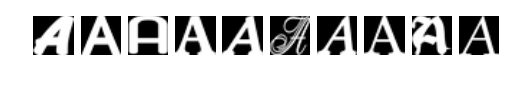

Some random letters from the notMNIST_small/B.pickle


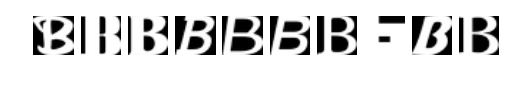

Some random letters from the notMNIST_small/C.pickle


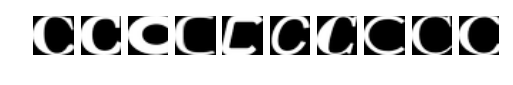

Some random letters from the notMNIST_small/D.pickle


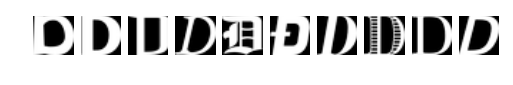

Some random letters from the notMNIST_small/E.pickle


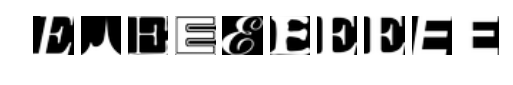

Some random letters from the notMNIST_small/F.pickle


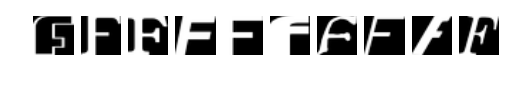

Some random letters from the notMNIST_small/G.pickle


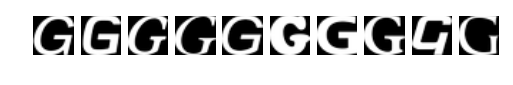

Some random letters from the notMNIST_small/H.pickle


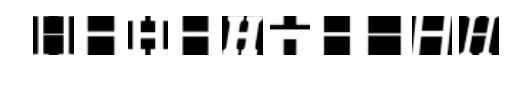

Some random letters from the notMNIST_small/I.pickle


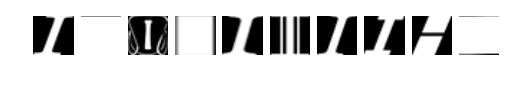

Some random letters from the notMNIST_small/J.pickle


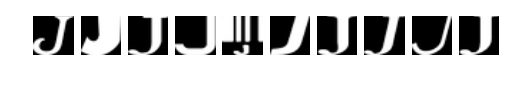

Some random letters from the notMNIST_large/A.pickle


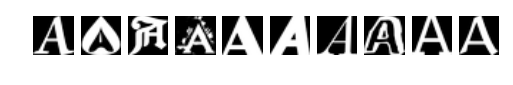

Some random letters from the notMNIST_large/B.pickle


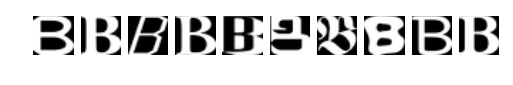

Some random letters from the notMNIST_large/C.pickle


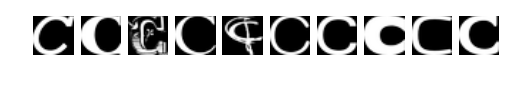

Some random letters from the notMNIST_large/D.pickle


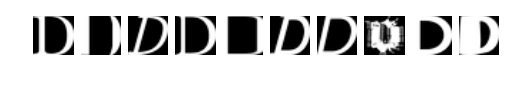

Some random letters from the notMNIST_large/E.pickle


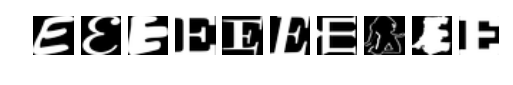

Some random letters from the notMNIST_large/F.pickle


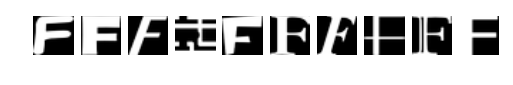

Some random letters from the notMNIST_large/G.pickle


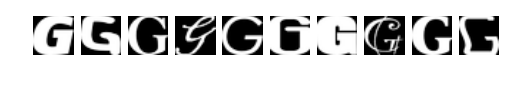

Some random letters from the notMNIST_large/H.pickle


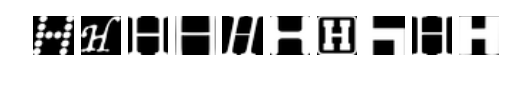

Some random letters from the notMNIST_large/I.pickle


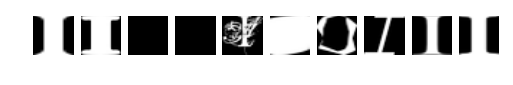

Some random letters from the notMNIST_large/J.pickle


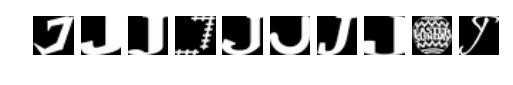

In [6]:
def show_letters(letters):
    fig = plt.figure()
    for i, letter in enumerate(letters):        
        ax = fig.add_subplot(1, len(letters), i + 1)
        ax.imshow(letter, cmap='Greys_r')
        ax.axis('off')            
    plt.show()
      
        
def letter_pickle_sample_display(datasets):   
    for letter_pickle_file in datasets:
        print("Some random letters from the " + letter_pickle_file)
        with open(letter_pickle_file, 'rb') as f:
            letter_set = pickle.load(f)                                                        
            random_indices = np.random.randint(0, letter_set.shape[0], 10)
            random_letters = letter_set[random_indices, :, :]  
            show_letters(random_letters)               
        
            
letter_pickle_sample_display(test_datasets)
letter_pickle_sample_display(train_datasets)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [7]:
def sample_num_display(datasets):  
    items_num = []
    for letter_pickle_file in datasets:
        with open(letter_pickle_file, 'rb') as f:
            letter_set = pickle.load(f)
            num = letter_set.shape[0]
            print(letter_pickle_file + ' %d letters' % num)
            items_num.append(num)           
            
sample_num_display(test_datasets)
sample_num_display(train_datasets)

notMNIST_small/A.pickle 1872 letters
notMNIST_small/B.pickle 1873 letters
notMNIST_small/C.pickle 1873 letters
notMNIST_small/D.pickle 1873 letters
notMNIST_small/E.pickle 1873 letters
notMNIST_small/F.pickle 1872 letters
notMNIST_small/G.pickle 1872 letters
notMNIST_small/H.pickle 1872 letters
notMNIST_small/I.pickle 1872 letters
notMNIST_small/J.pickle 1872 letters
notMNIST_large/A.pickle 52909 letters
notMNIST_large/B.pickle 52911 letters
notMNIST_large/C.pickle 52912 letters
notMNIST_large/D.pickle 52911 letters
notMNIST_large/E.pickle 52912 letters
notMNIST_large/F.pickle 52912 letters
notMNIST_large/G.pickle 52912 letters
notMNIST_large/H.pickle 52912 letters
notMNIST_large/I.pickle 52912 letters
notMNIST_large/J.pickle 52911 letters


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels


train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Letters in train dataset: 200000, labels: 200000
First labels:  ['E', 'J', 'G', 'C', 'H', 'D', 'F', 'J', 'G', 'E', 'H', 'G', 'A', 'B', 'I', 'A', 'B', 'J', 'G', 'F']


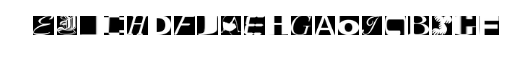

Labels 0 (A): 20000
Labels 1 (B): 20000
Labels 2 (C): 20000
Labels 3 (D): 20000
Labels 4 (E): 20000
Labels 5 (F): 20000
Labels 6 (G): 20000
Labels 7 (H): 20000
Labels 8 (I): 20000
Labels 9 (J): 20000

Letters in valid dataset: 10000, labels: 10000
First labels:  ['B', 'J', 'D', 'I', 'J', 'D', 'J', 'H', 'A', 'H', 'D', 'E', 'J', 'C', 'E', 'C', 'E', 'C', 'H', 'B']


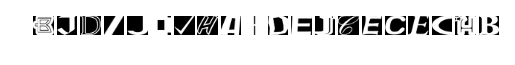

Labels 0 (A): 1000
Labels 1 (B): 1000
Labels 2 (C): 1000
Labels 3 (D): 1000
Labels 4 (E): 1000
Labels 5 (F): 1000
Labels 6 (G): 1000
Labels 7 (H): 1000
Labels 8 (I): 1000
Labels 9 (J): 1000

Letters in test dataset: 10000, labels: 10000
First labels:  ['D', 'G', 'E', 'H', 'H', 'H', 'H', 'B', 'H', 'E', 'G', 'A', 'J', 'A', 'A', 'C', 'C', 'I', 'C', 'J']


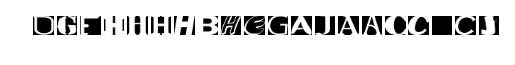

Labels 0 (A): 1000
Labels 1 (B): 1000
Labels 2 (C): 1000
Labels 3 (D): 1000
Labels 4 (E): 1000
Labels 5 (F): 1000
Labels 6 (G): 1000
Labels 7 (H): 1000
Labels 8 (I): 1000
Labels 9 (J): 1000



In [10]:
def alphabetic_label(i):
    return chr(ord('A') + i)

def shaffled_dataset_display(name, dataset, labels):
    samples = 20
    print("Letters in %s dataset: %d, labels: %d" % (name, len(dataset), len(labels)))
    print("First labels: ", end=' ')  
    print([alphabetic_label(i) for i in labels[0:samples]])
    show_letters(dataset[0:samples, :, :])
    
    total_labels = 0
    for i in range(10):
        s = np.count_nonzero(labels == i)
        print("Labels %d (%s): %d" % (i, alphabetic_label(i), s))
        total_labels += s

    if total_labels != len(labels):
        raise Exception('Verification error in ' + name + ' dataset')        
    print()
    
shaffled_dataset_display('train', train_dataset, train_labels)       
shaffled_dataset_display('valid', valid_dataset, valid_labels)
shaffled_dataset_display('test', test_dataset, test_labels)

Finally, let's save the data for later reuse:

In [11]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [12]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


1.0 17 20
8 8


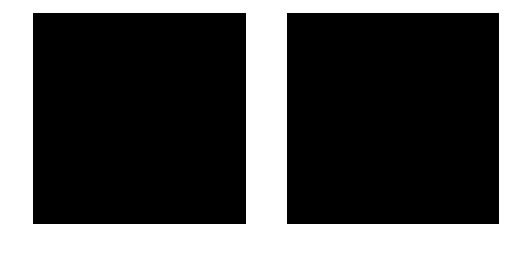

0.999648683035 17 60
8 8


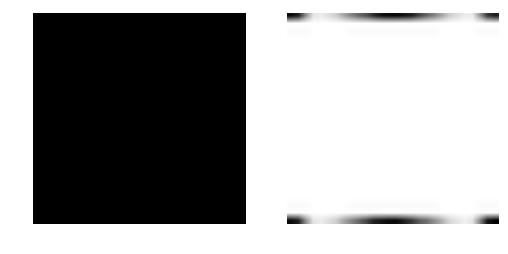

0.999973087277 17 249
8 8


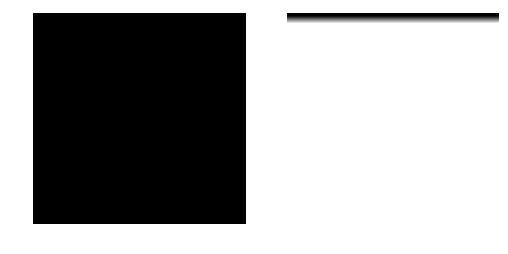

1.0 17 264
8 8


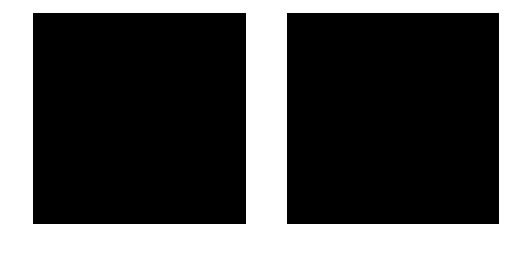

1.0 17 280
8 8


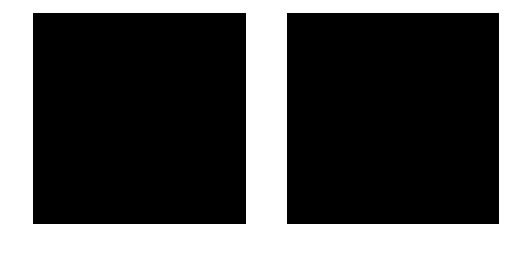

1.0 17 297
8 8


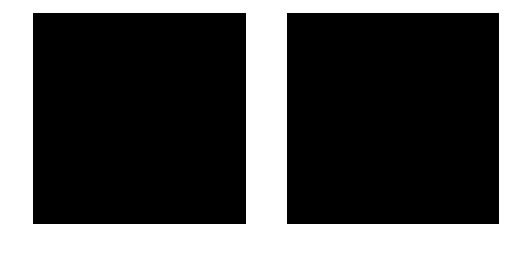

1.0 17 303
8 8


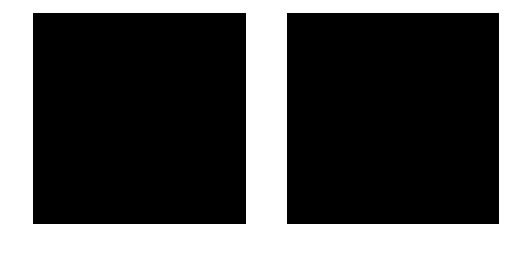

0.995987434406 17 337
8 8


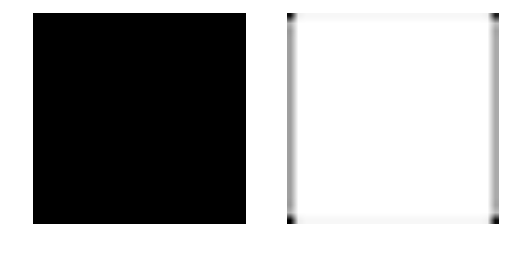

1.0 17 393
8 8


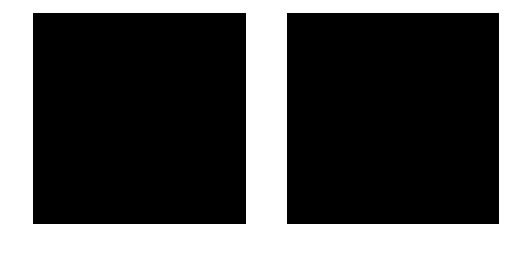

0.997748119291 17 407
8 8


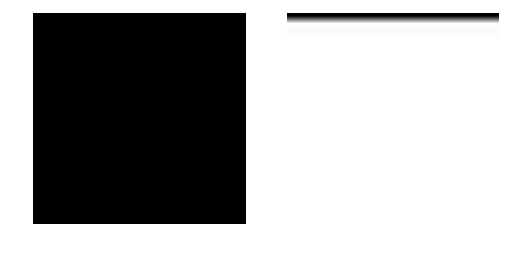

1.0 17 444
8 8


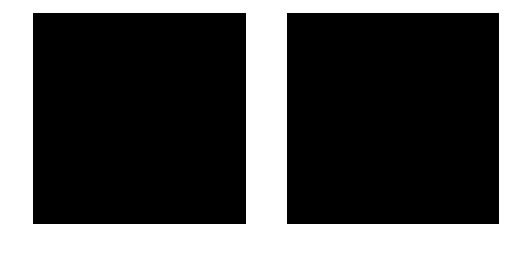

1.0 17 538
8 8


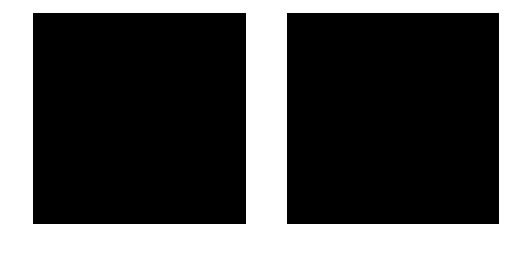

1.0 17 761
8 8


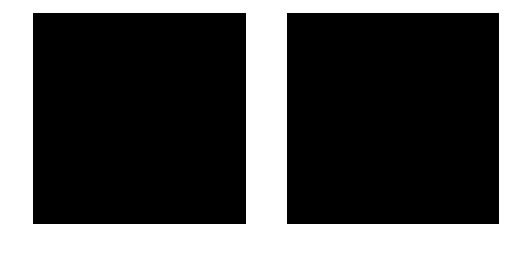

1.0 17 849
8 8


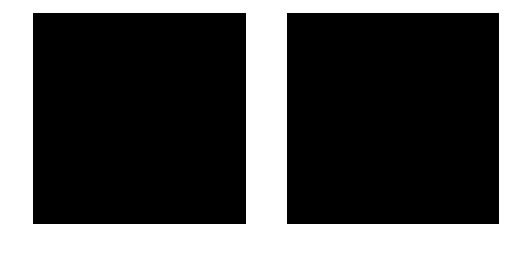

1.0 17 887
8 8


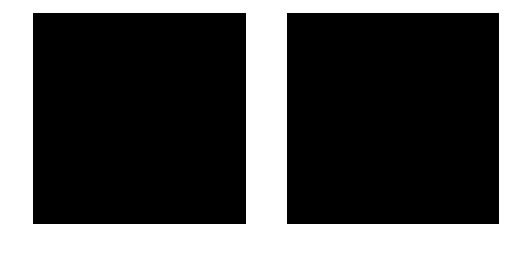

1.0 17 965
8 8


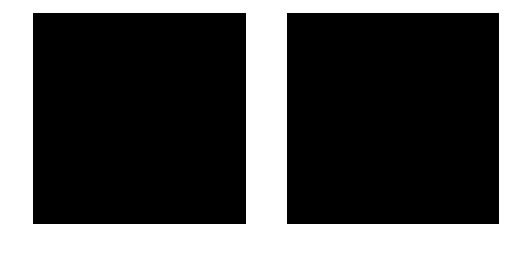

0.999648683035 20 60
8 8


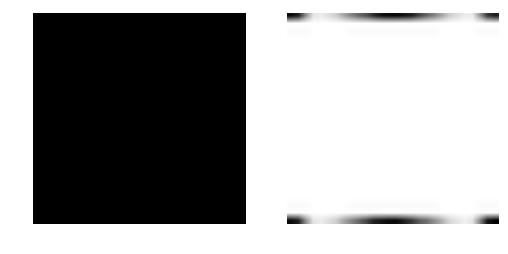

0.999973087277 20 249
8 8


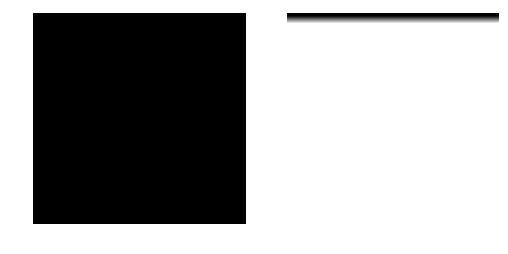

1.0 20 264
8 8


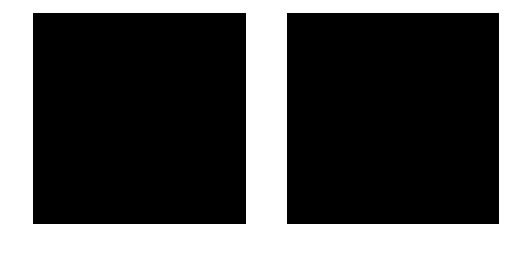

1.0 20 280
8 8


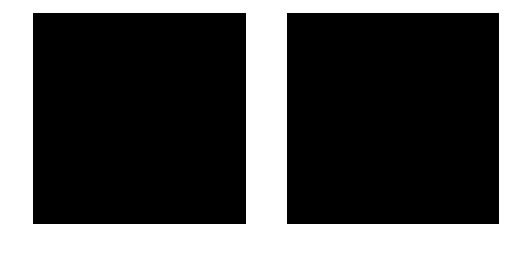

1.0 20 297
8 8


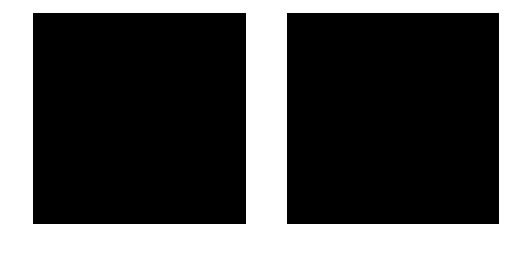

1.0 20 303
8 8


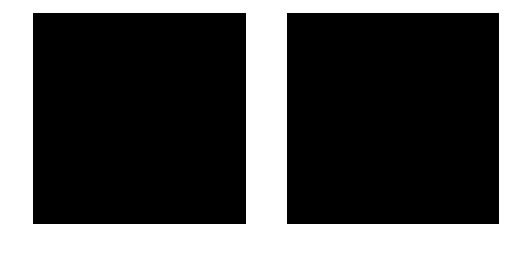

0.995987434406 20 337
8 8


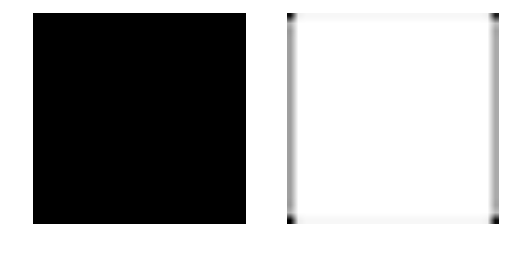

1.0 20 393
8 8


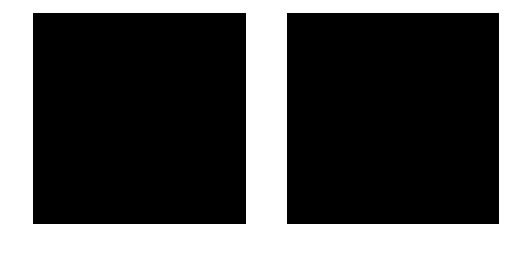

0.997748119291 20 407
8 8


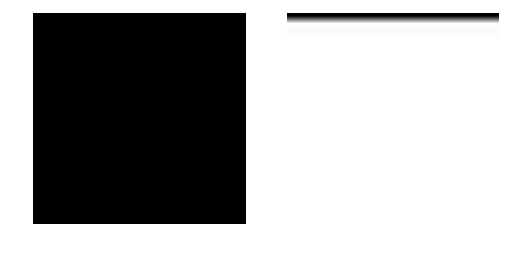

1.0 20 444
8 8


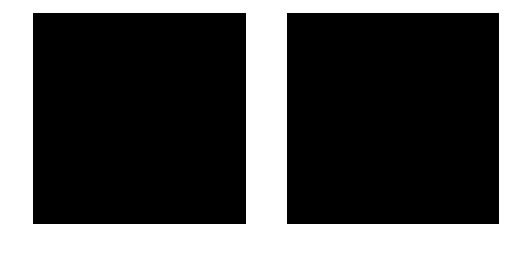

1.0 20 538
8 8


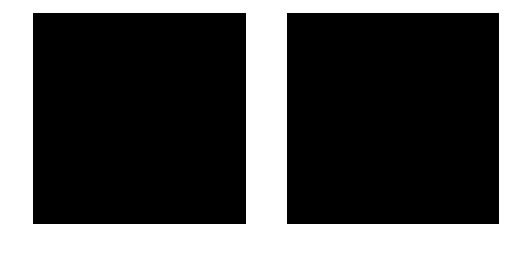

1.0 20 761
8 8


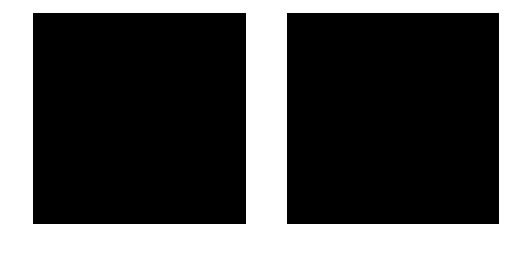

1.0 20 849
8 8


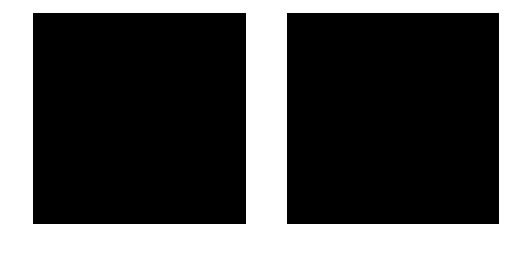

1.0 20 887
8 8


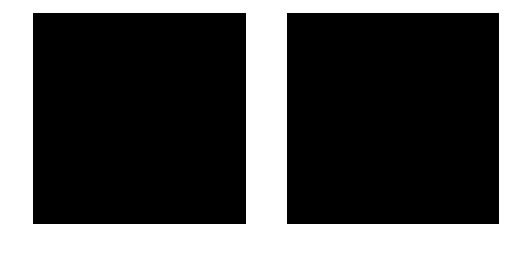

1.0 20 965
8 8


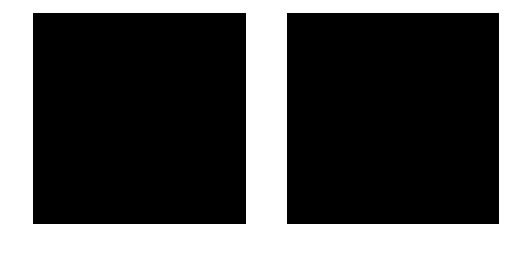

0.988770076074 21 32
8 8


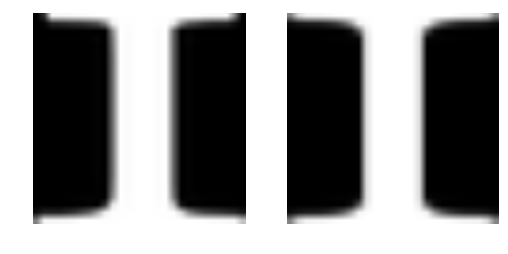

0.980012495071 21 900
8 8


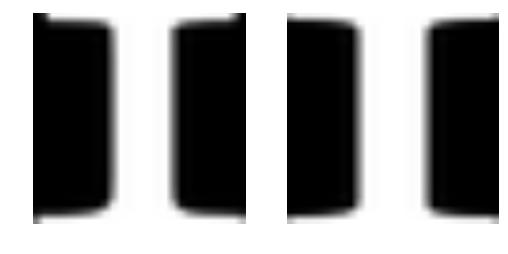

0.983249180019 21 976
8 8


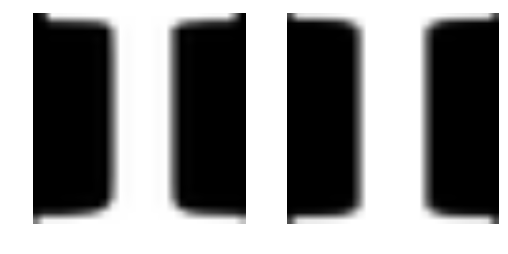

0.992437131703 24 36
5 5


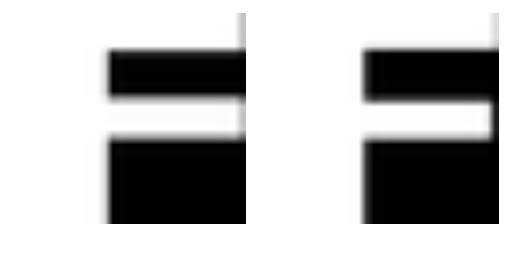

0.988253301941 24 628
5 5


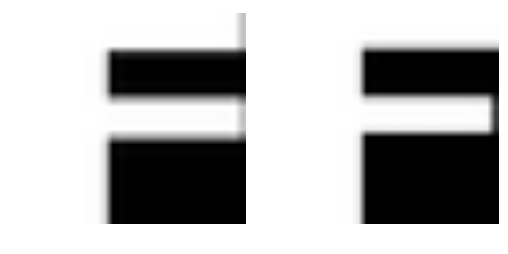

0.983129546046 24 975
5 5


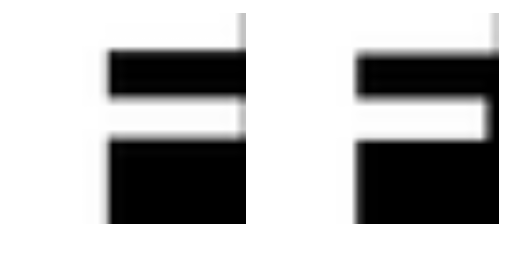

0.998224191484 30 378
0 0


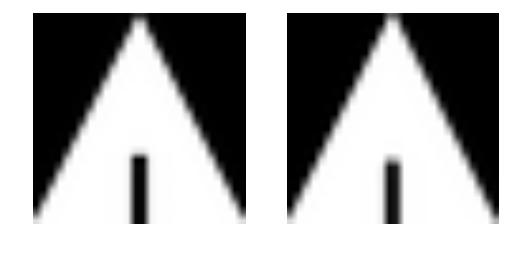

0.986744030379 32 900
8 8


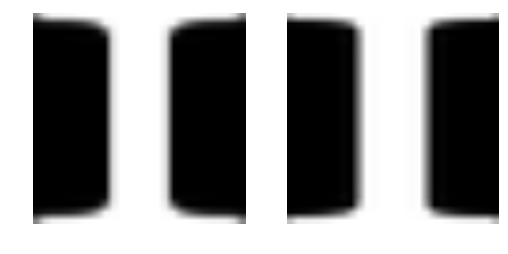

0.991000341251 32 976
8 8


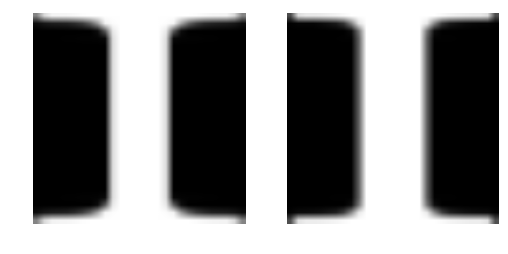

0.983417561278 36 628
5 5


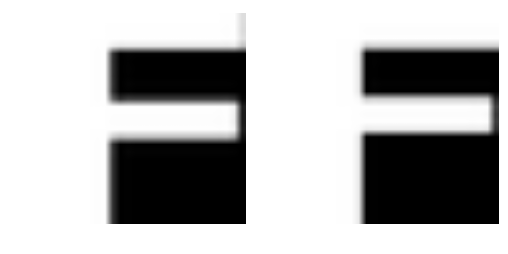

0.989243304357 42 650
1 1


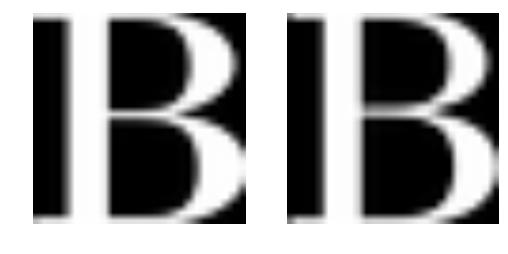

0.989225022495 44 166
2 2


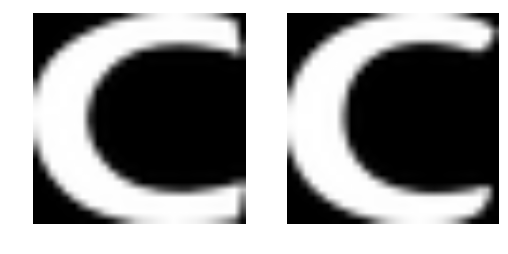

0.984205858782 44 457
2 2


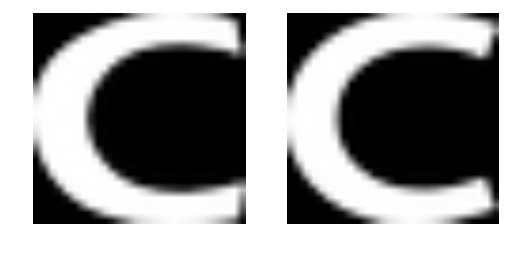

0.984301347286 57 969
0 0


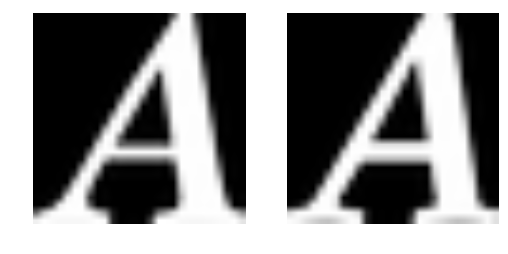

0.982865773141 59 383
8 8


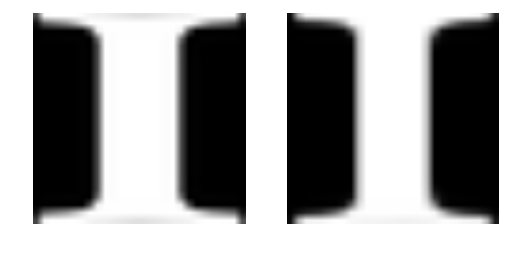

0.983599636704 59 809
8 8


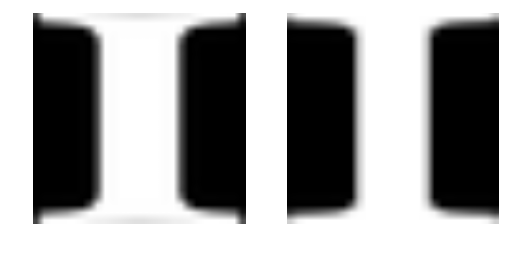

0.99974479989 60 249
8 8


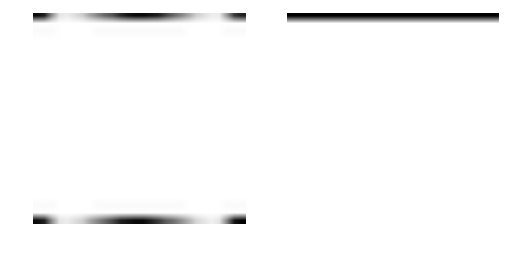

0.999648683035 60 264
8 8


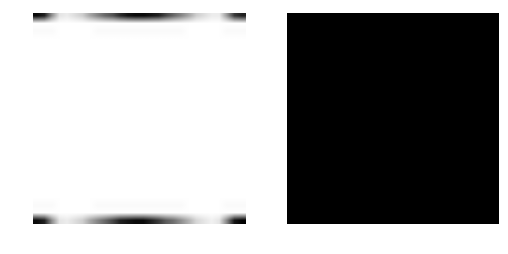

0.999648683035 60 280
8 8


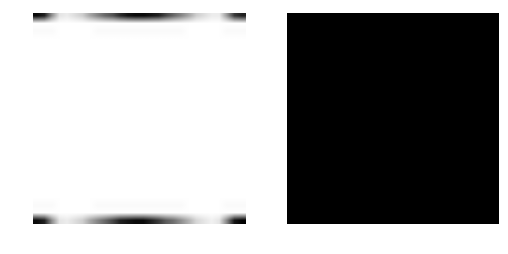

0.999648683035 60 297
8 8


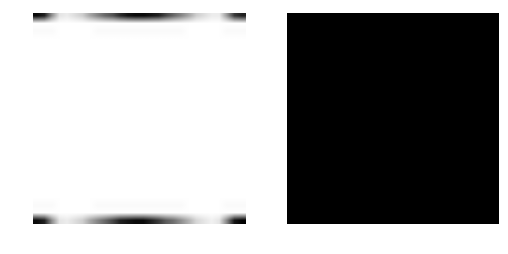

0.999648683035 60 303
8 8


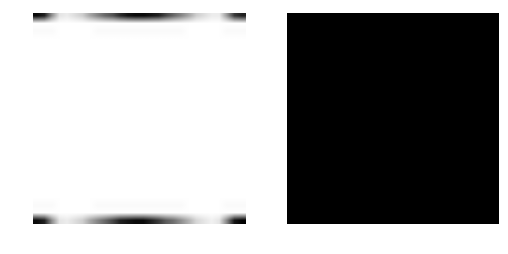

0.996374216629 60 337
8 8


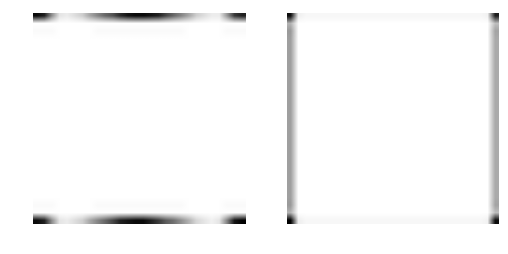

0.999648683035 60 393
8 8


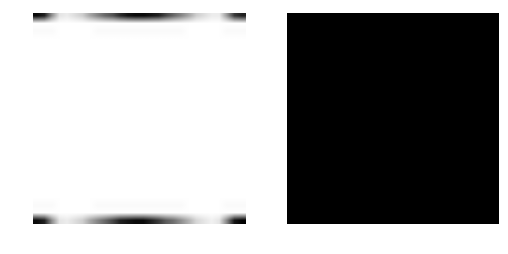

0.998523056391 60 407
8 8


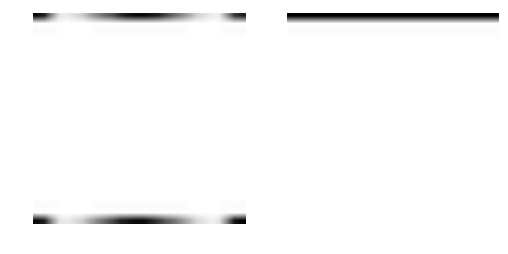

0.999648683035 60 444
8 8


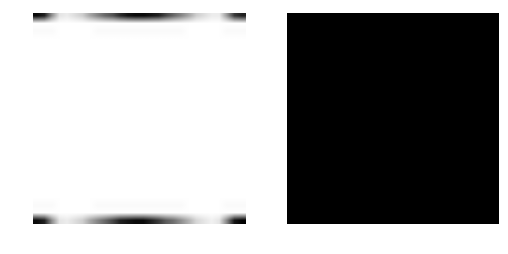

0.999648683035 60 538
8 8


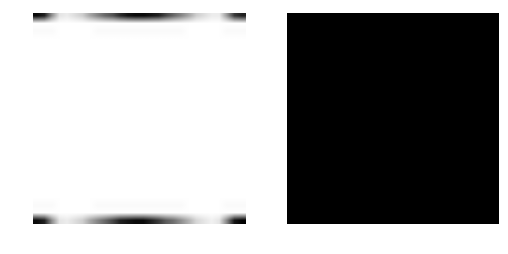

0.999648683035 60 761
8 8


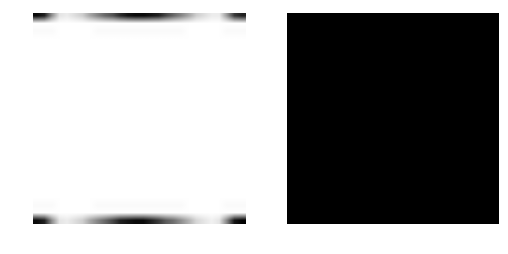

0.999648683035 60 849
8 8


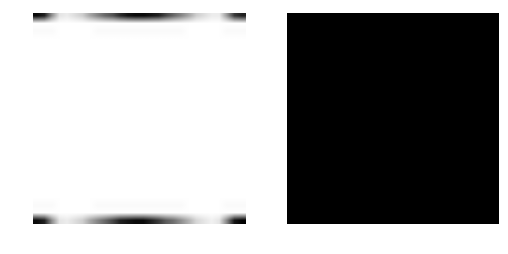

0.999648683035 60 887
8 8


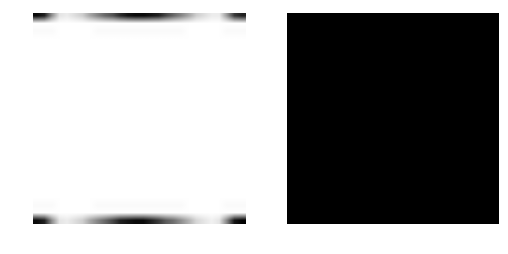

0.999648683035 60 965
8 8


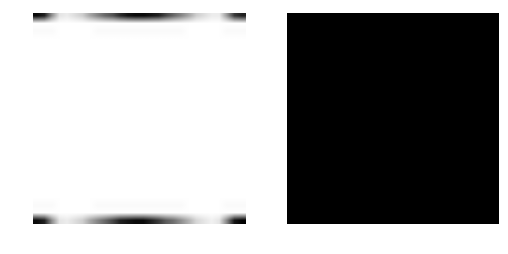

0.981834989041 66 325
0 0


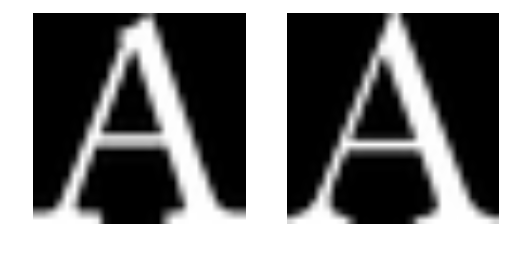

0.98017803207 76 188
9 9


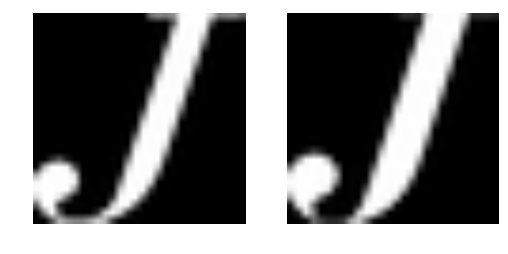

0.985369049944 83 578
3 3


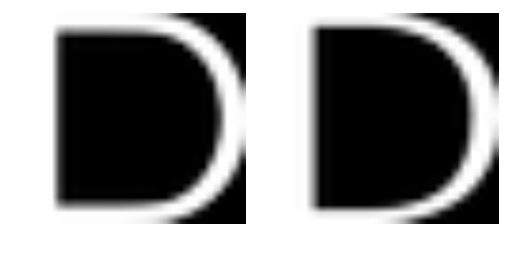

0.983577763662 84 531
4 4


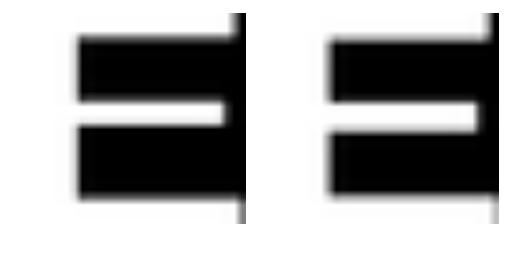

0.99856138532 96 285
2 2


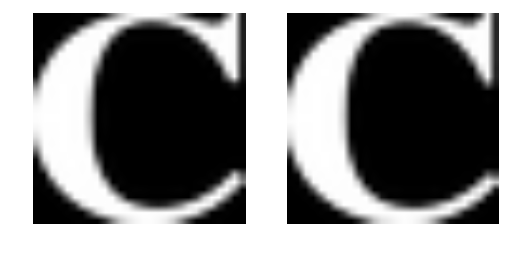

0.991691950709 100 354
8 8


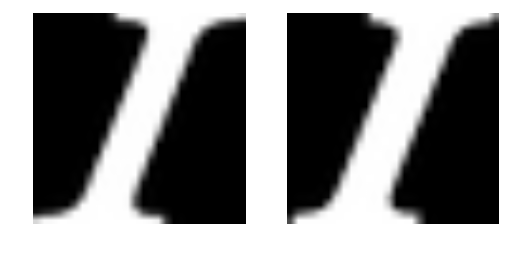

0.990144684911 100 577
8 8


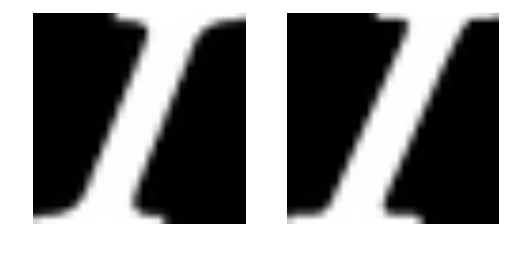

0.982433933765 100 777
8 8


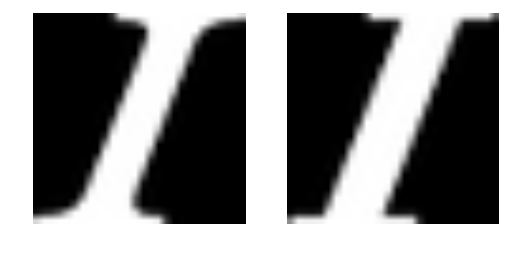

0.986250401475 101 979
2 6


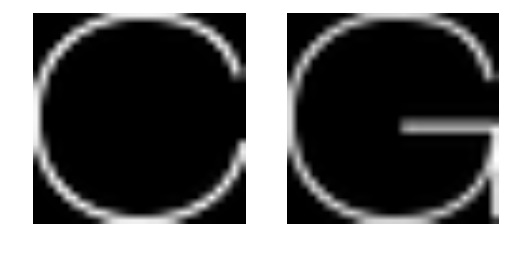

0.982107529417 111 479
3 3


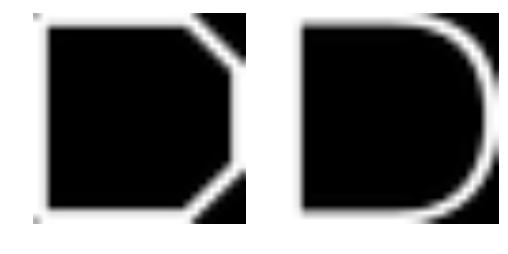

0.993682786357 117 553
3 3


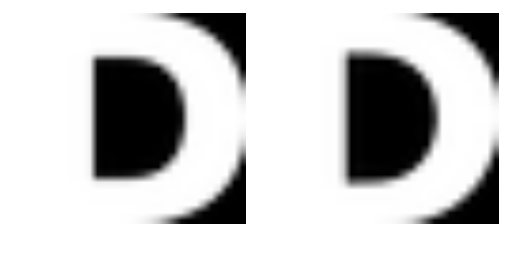

0.981085062027 122 846
2 2


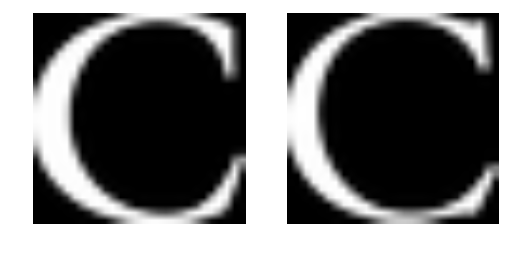

0.988008281216 129 572
5 5


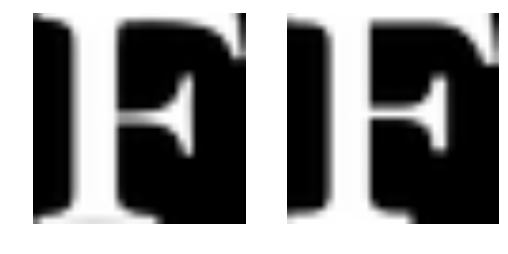

0.980100059882 131 277
4 4


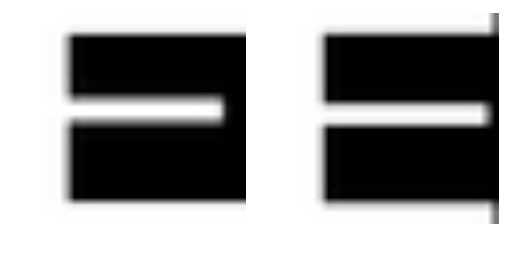

0.981161817908 142 797
1 1


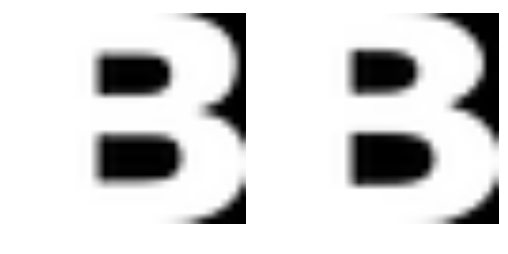

0.985731723718 144 713
3 3


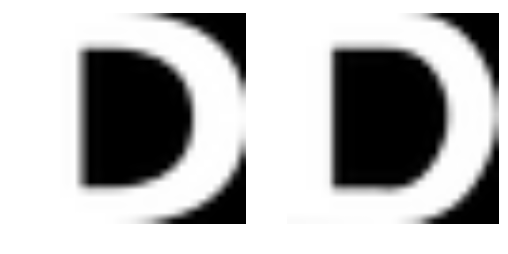

0.996592224808 157 433
9 9


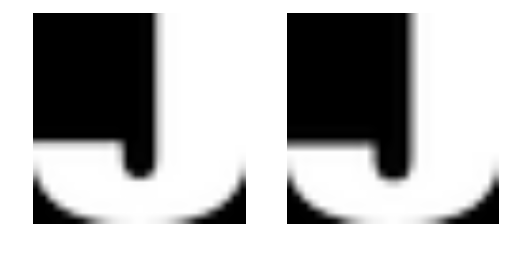

0.988424213603 163 307
8 8


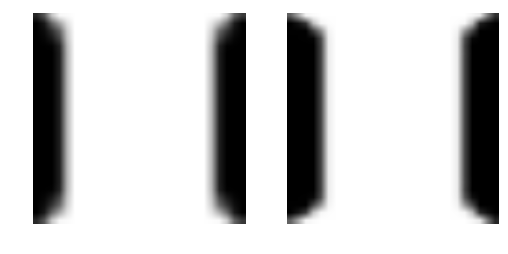

0.987515064888 163 714
8 8


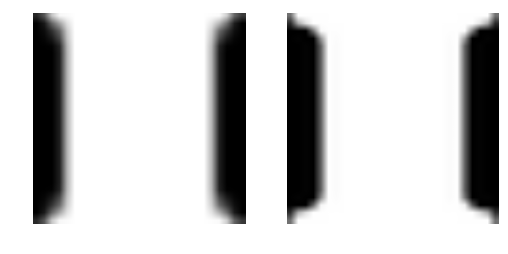

0.982752257958 166 457
2 2


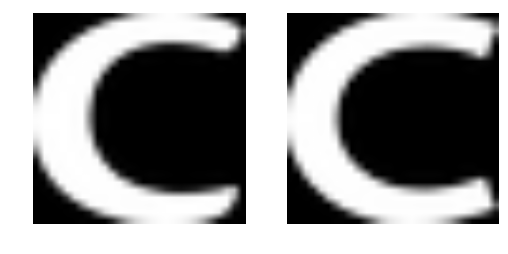

0.982242936268 174 683
7 7


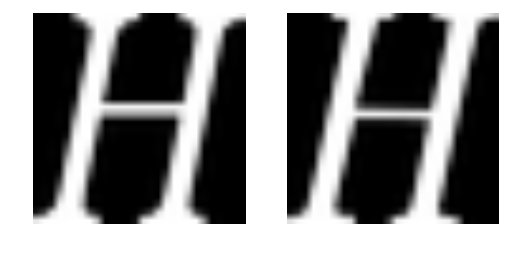

0.993835278787 200 368
6 6


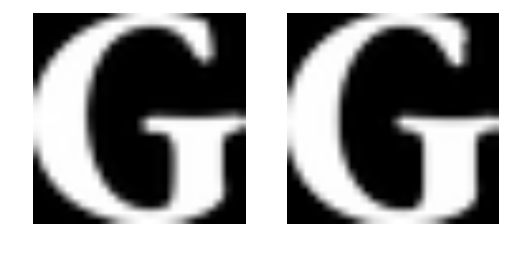

0.980063632131 213 364
8 8


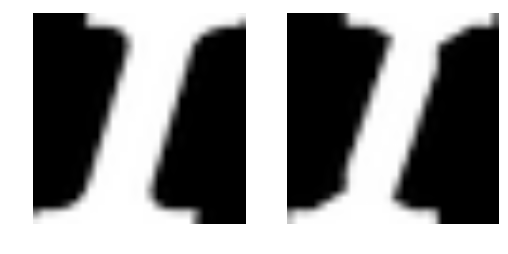

0.985908989795 213 491
8 8


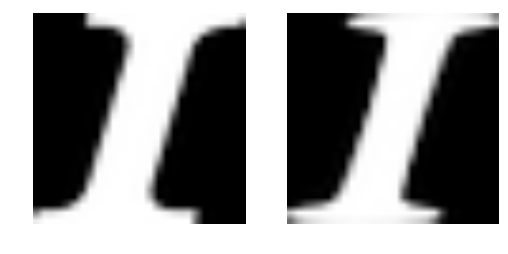

0.994557274971 218 655
4 4


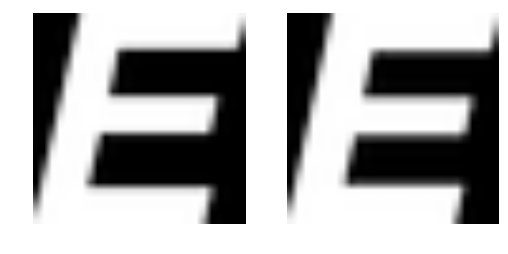

0.985625466332 221 387
1 1


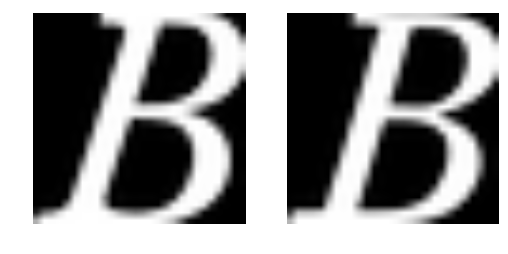

0.981424059719 223 546
8 8


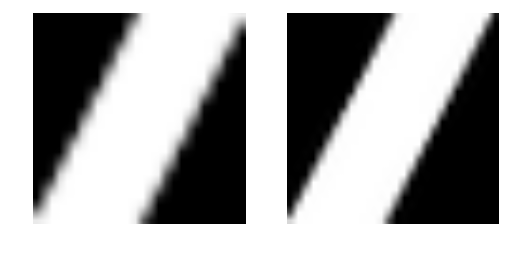

0.999787954381 223 780
8 8


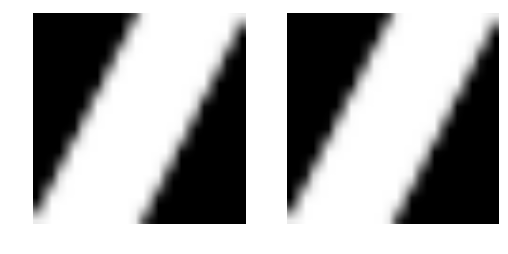

0.980262575671 223 895
8 8


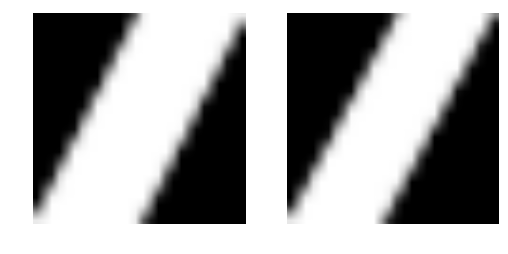

0.993320896756 226 496
8 8


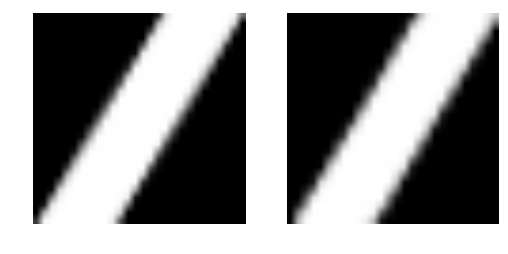

0.997548352694 230 383
8 8


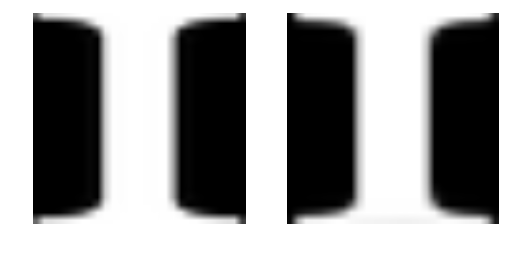

0.995416480582 230 809
8 8


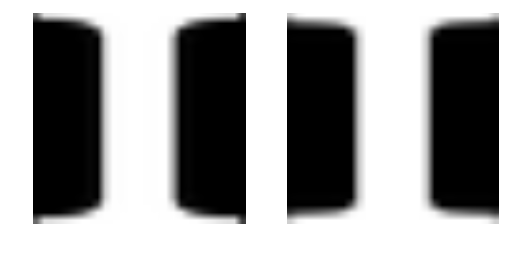

0.99469648581 230 900
8 8


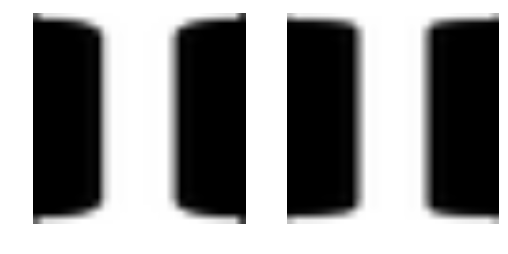

0.991264740936 230 976
8 8


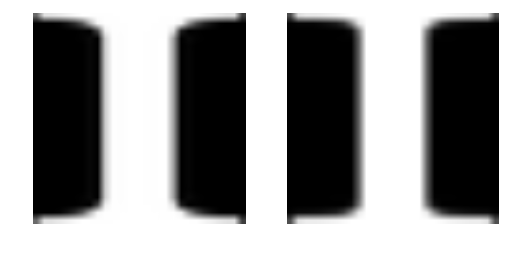

0.984022157267 233 343
4 4


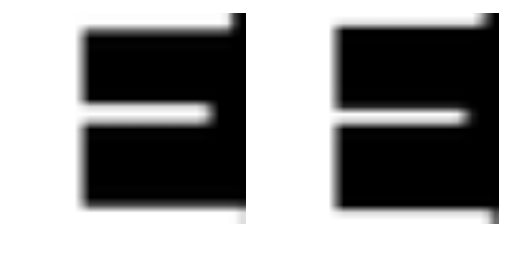

0.992179910652 234 834
7 7


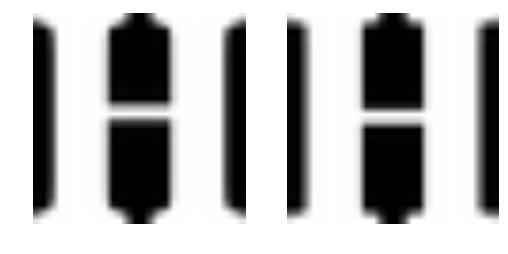

0.981958802789 245 950
9 9


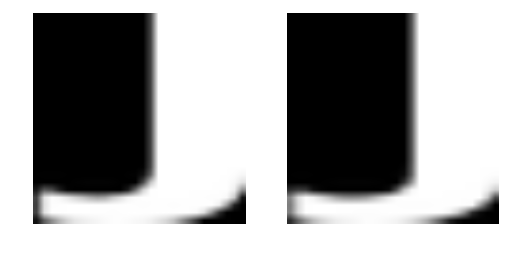

0.999973087277 249 264
8 8


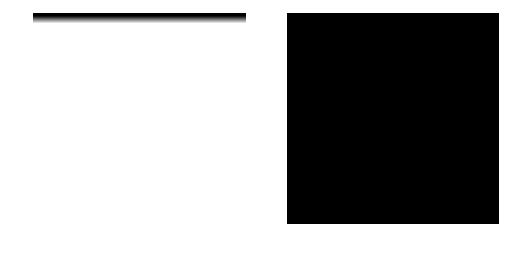

0.999973087277 249 280
8 8


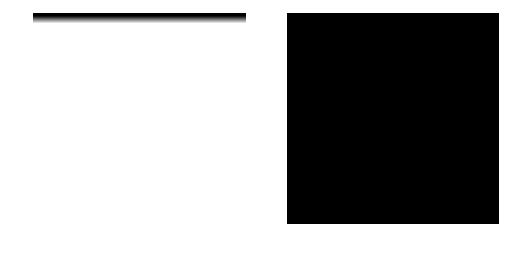

0.999973087277 249 297
8 8


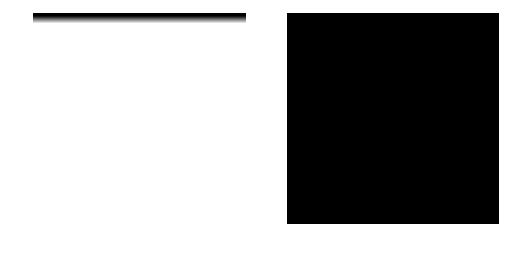

0.999973087277 249 303
8 8


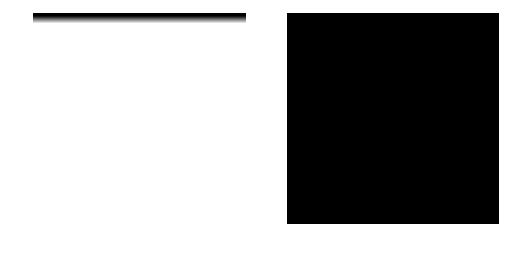

0.996081354562 249 337
8 8


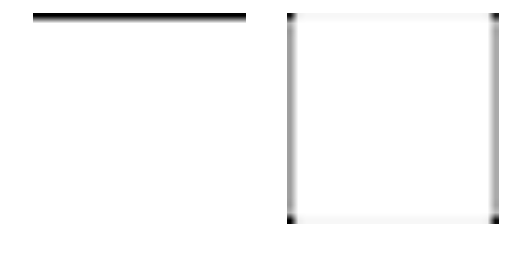

0.999973087277 249 393
8 8


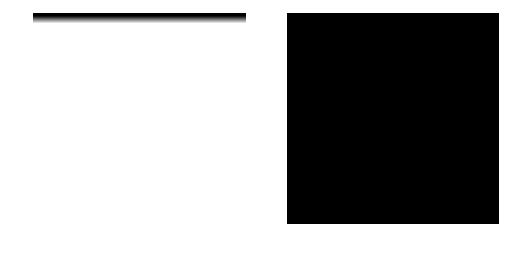

0.998213324579 249 407
8 8


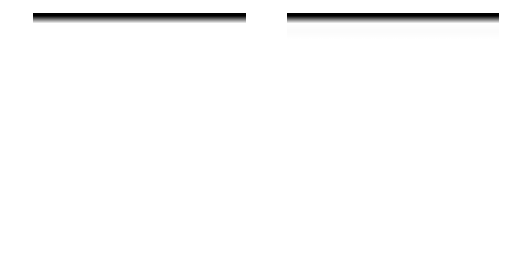

0.999973087277 249 444
8 8


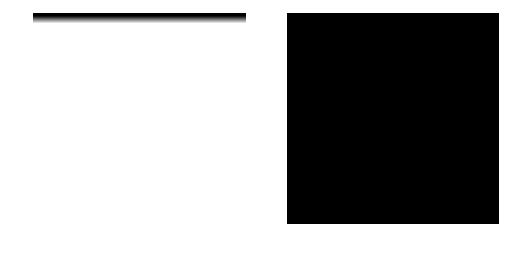

0.999973087277 249 538
8 8


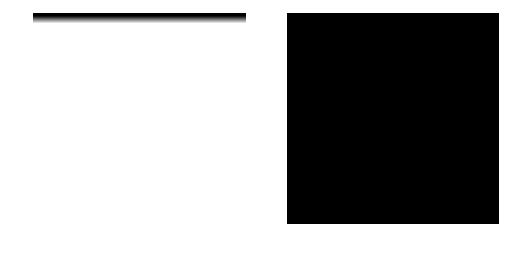

0.999973087277 249 761
8 8


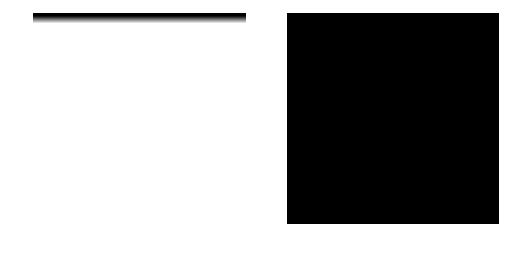

0.999973087277 249 849
8 8


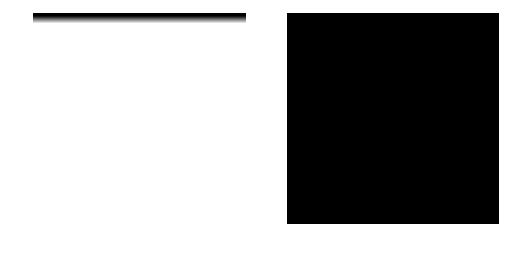

0.999973087277 249 887
8 8


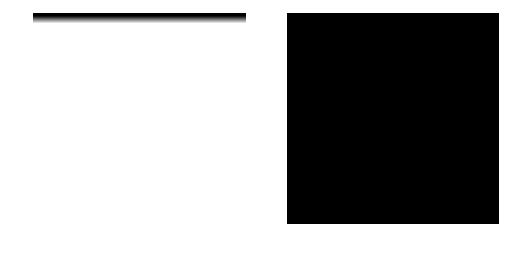

0.999973087277 249 965
8 8


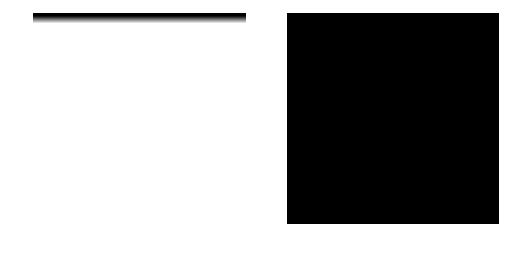

0.992917657364 262 335
7 7


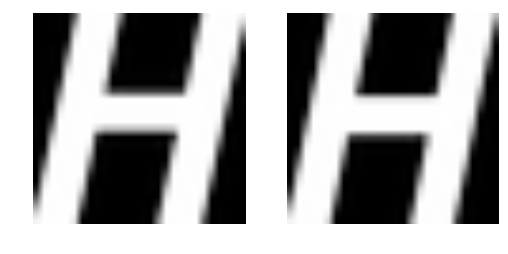

1.0 264 280
8 8


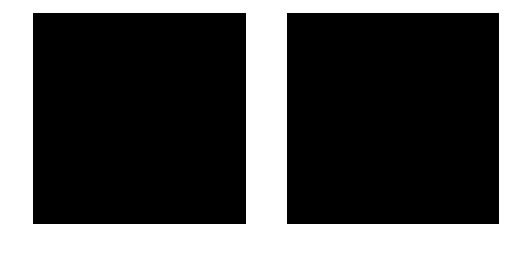

1.0 264 297
8 8


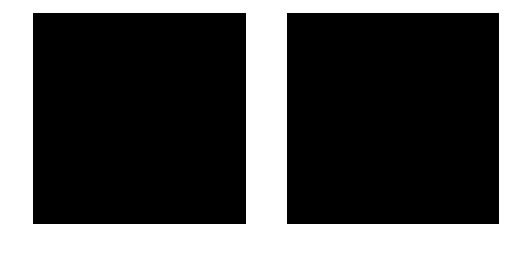

1.0 264 303
8 8


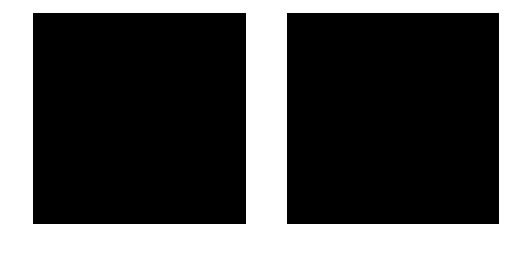

0.995987434406 264 337
8 8


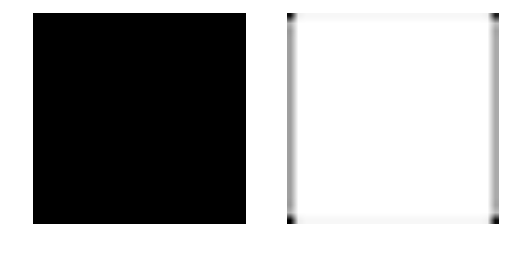

1.0 264 393
8 8


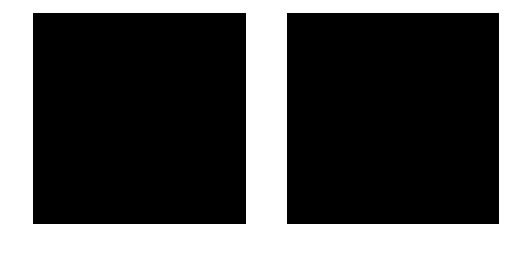

0.997748119291 264 407
8 8


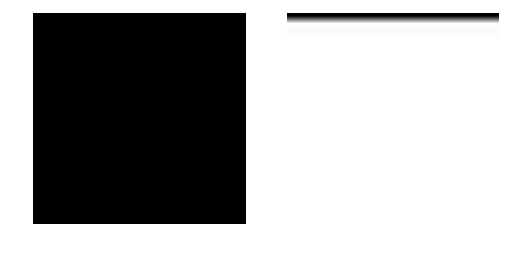

1.0 264 444
8 8


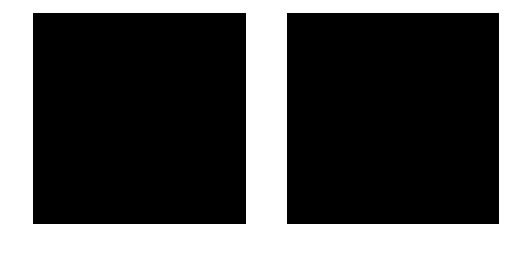

1.0 264 538
8 8


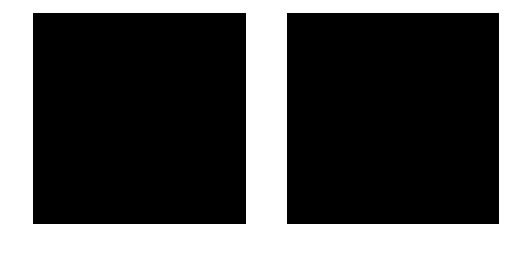

1.0 264 761
8 8


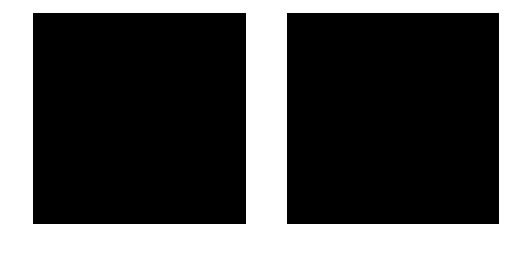

1.0 264 849
8 8


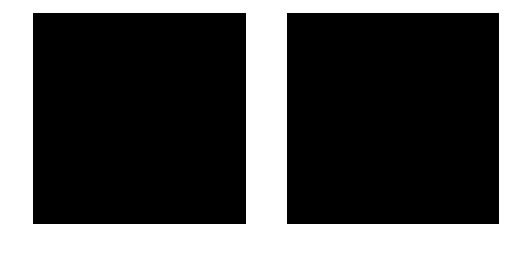

1.0 264 887
8 8


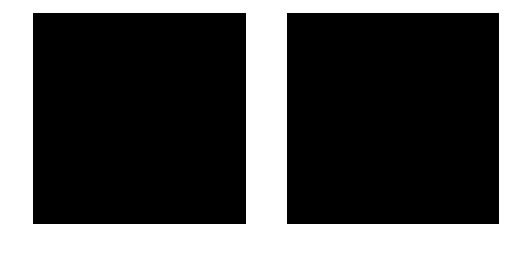

1.0 264 965
8 8


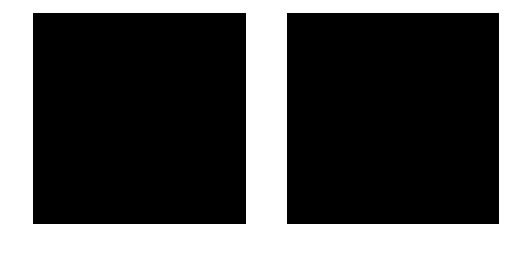

0.988244923763 265 671
7 7


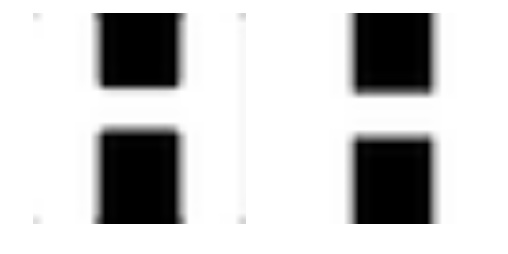

0.980999400839 265 824
7 7


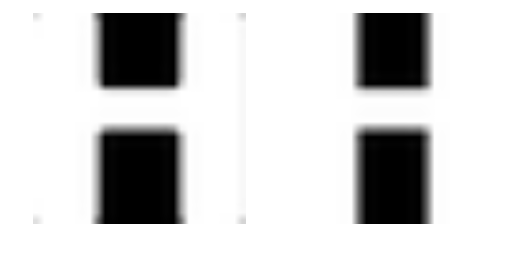

0.996777848341 267 581
7 7


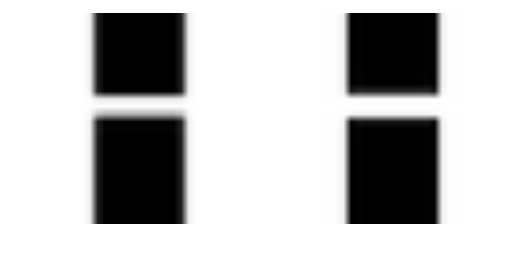

0.984343482181 268 739
9 9


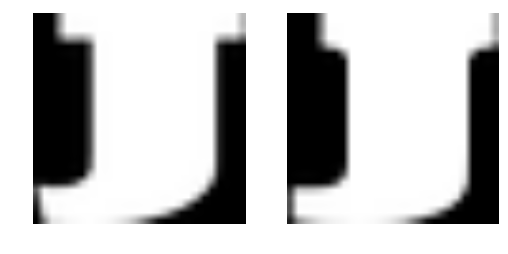

0.985597355291 277 930
4 4


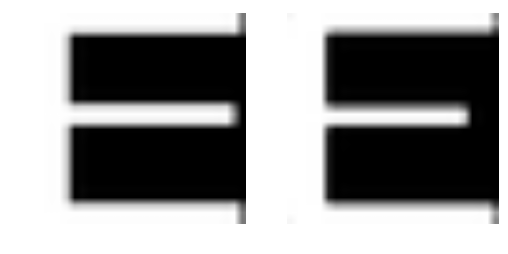

1.0 280 297
8 8


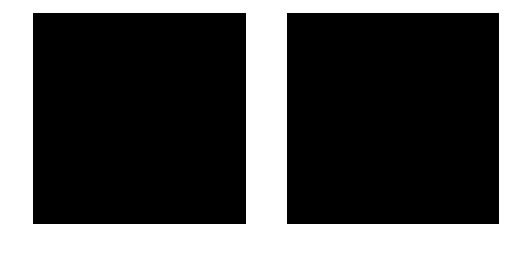

1.0 280 303
8 8


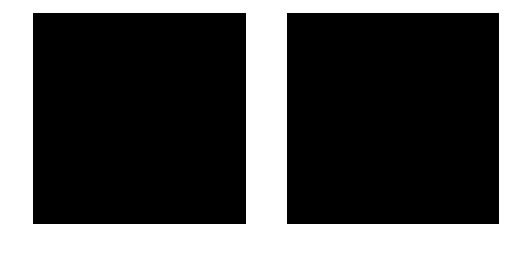

0.995987434406 280 337
8 8


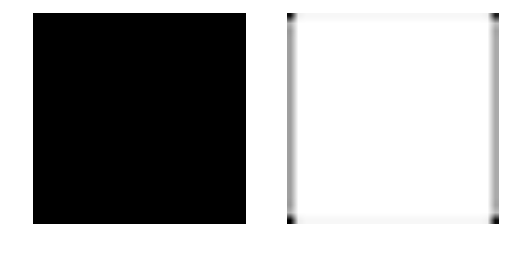

1.0 280 393
8 8


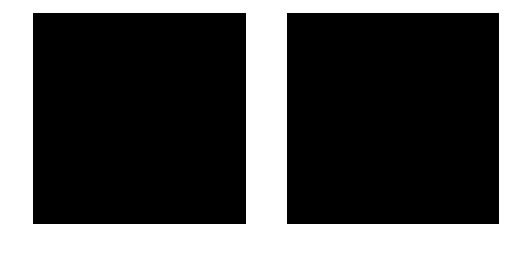

0.997748119291 280 407
8 8


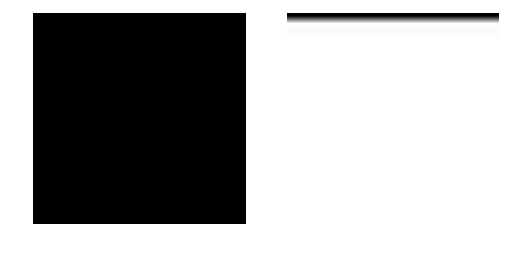

1.0 280 444
8 8


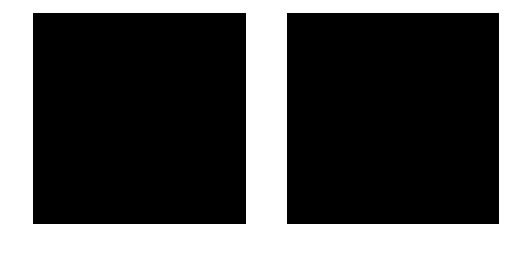

1.0 280 538
8 8


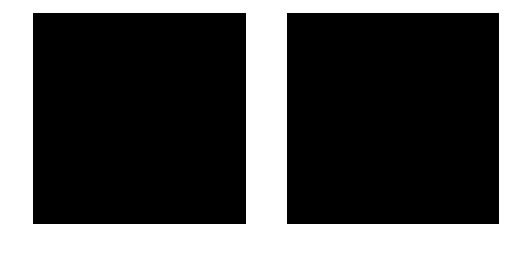

1.0 280 761
8 8


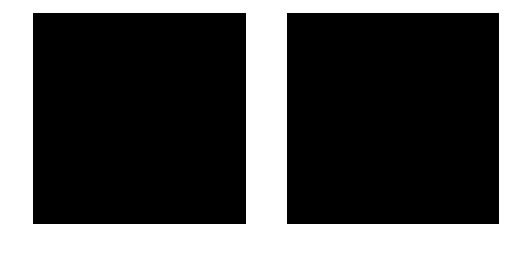

1.0 280 849
8 8


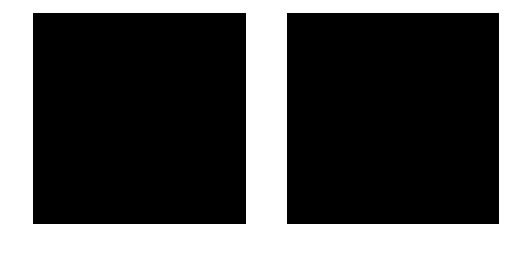

1.0 280 887
8 8


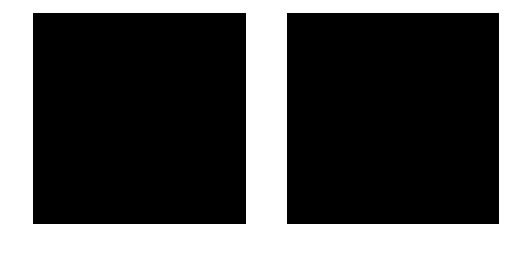

1.0 280 965
8 8


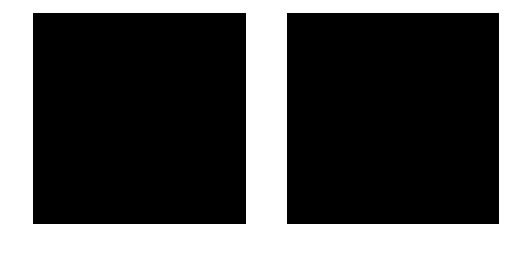

1.0 297 303
8 8


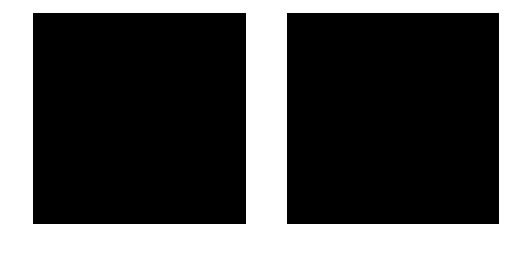

0.995987434406 297 337
8 8


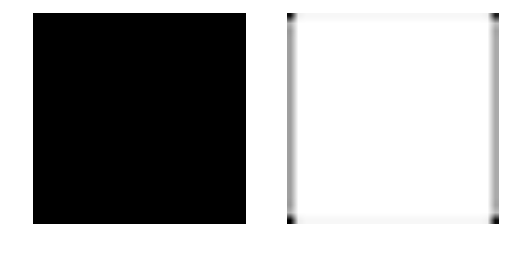

1.0 297 393
8 8


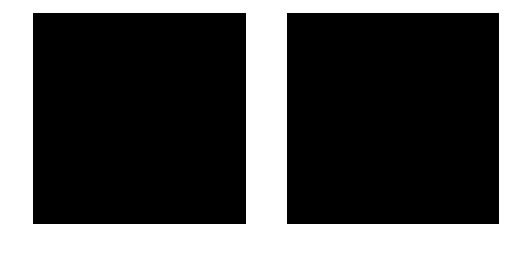

0.997748119291 297 407
8 8


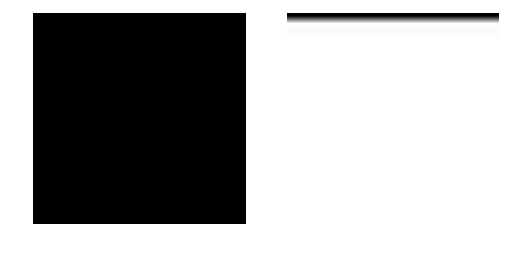

1.0 297 444
8 8


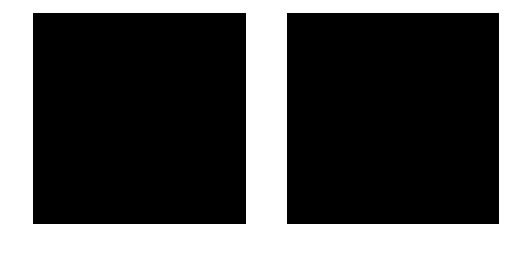

1.0 297 538
8 8


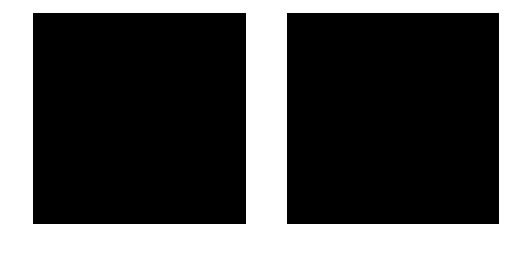

1.0 297 761
8 8


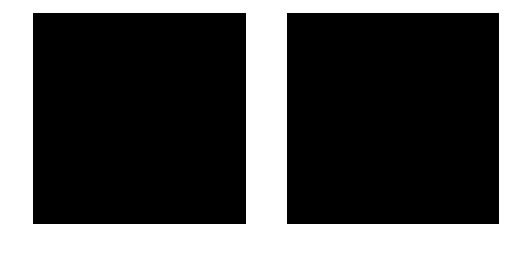

1.0 297 849
8 8


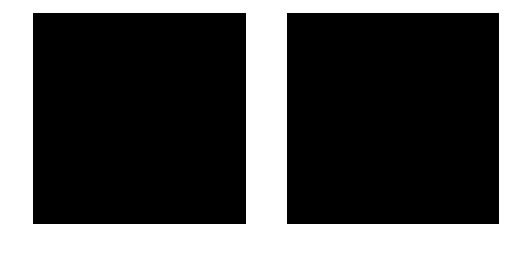

1.0 297 887
8 8


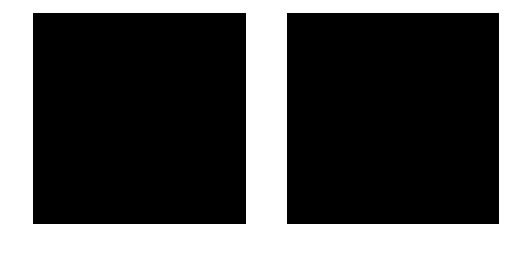

1.0 297 965
8 8


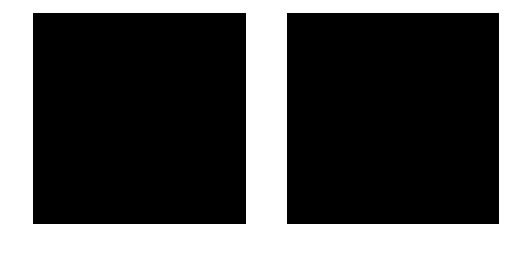

0.995987434406 303 337
8 8


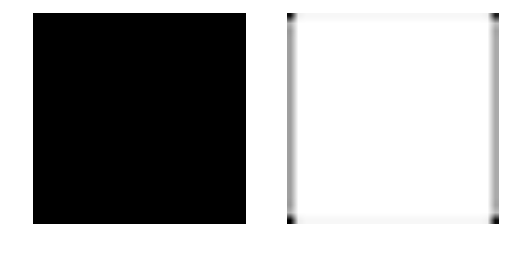

1.0 303 393
8 8


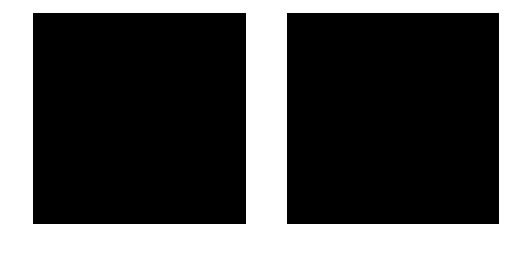

0.997748119291 303 407
8 8


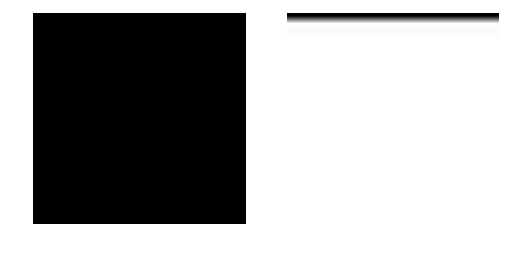

1.0 303 444
8 8


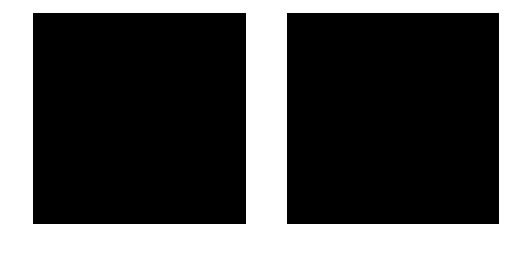

1.0 303 538
8 8


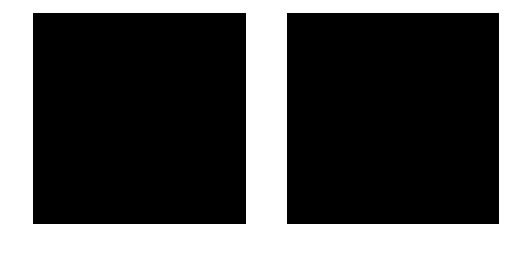

1.0 303 761
8 8


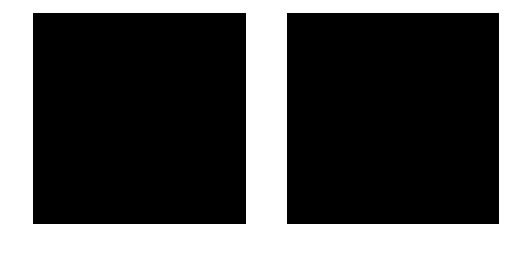

1.0 303 849
8 8


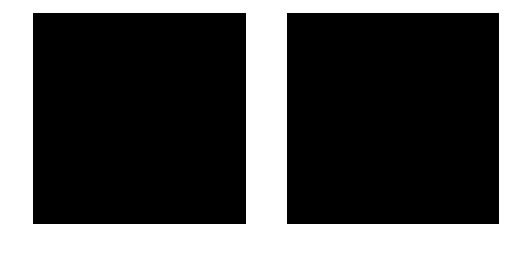

1.0 303 887
8 8


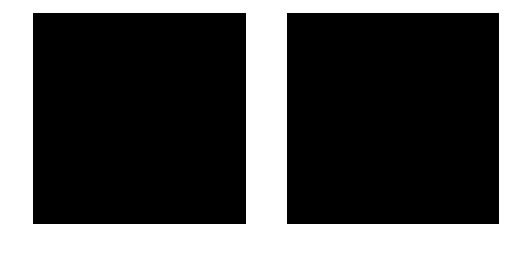

1.0 303 965
8 8


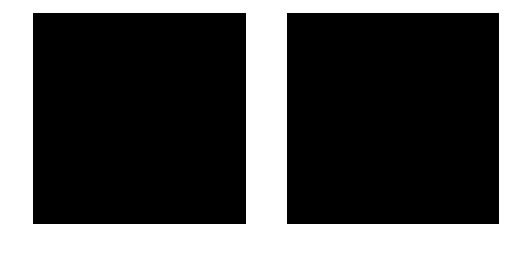

0.991077960469 307 714
8 8


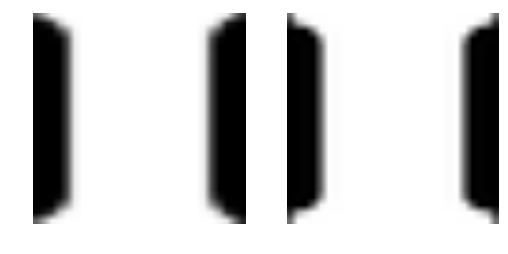

0.984312804416 317 426
7 7


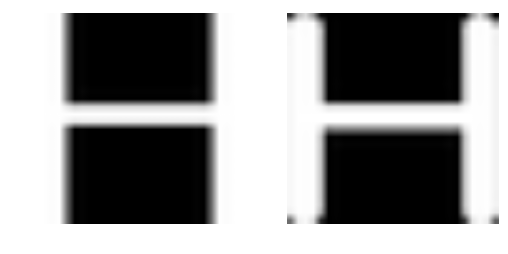

0.994745466858 318 783
8 8


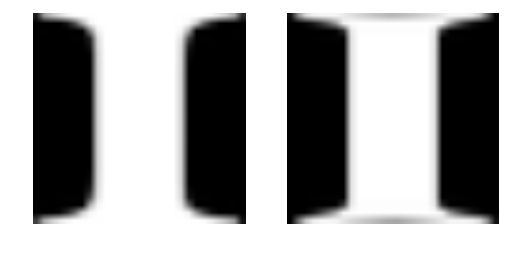

0.995987434406 337 393
8 8


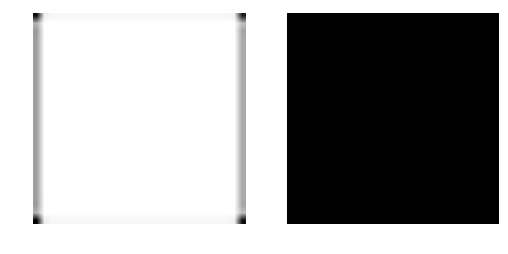

0.994849096984 337 407
8 8


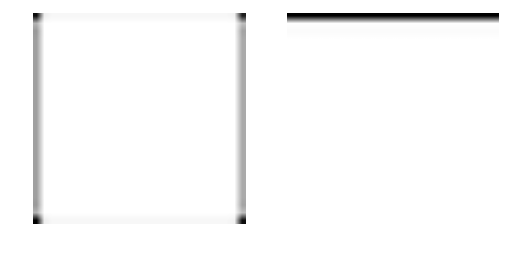

0.995987434406 337 444
8 8


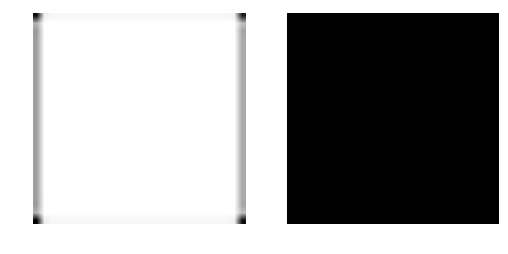

0.995987434406 337 538
8 8


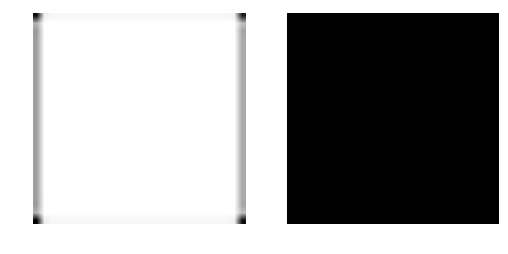

0.995987434406 337 761
8 8


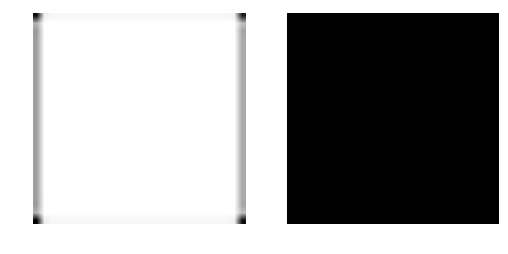

0.995987434406 337 849
8 8


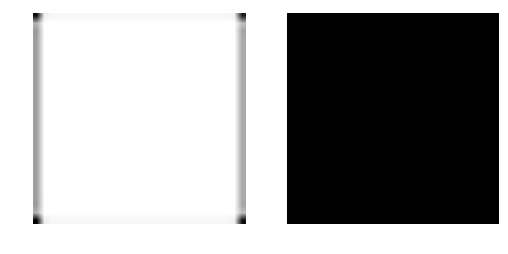

0.995987434406 337 887
8 8


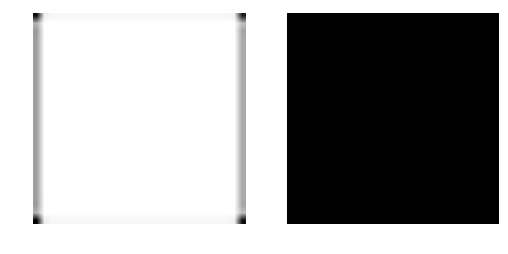

0.995987434406 337 965
8 8


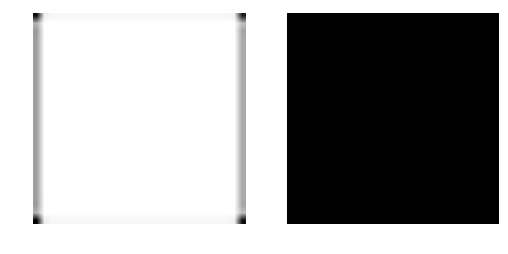

0.986715332605 347 350
4 4


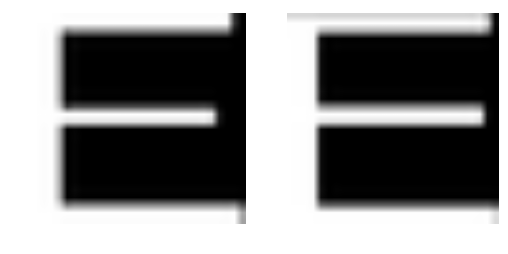

0.983222935349 352 354
8 8


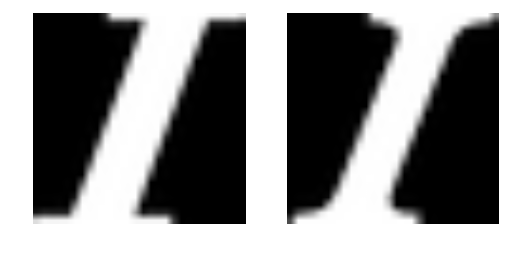

0.993413325865 352 777
8 8


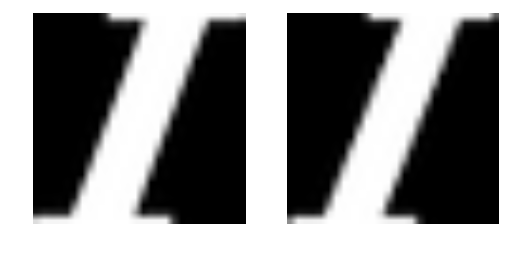

0.986588850617 354 577
8 8


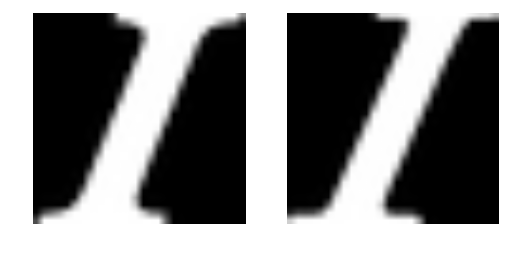

0.988365189172 354 777
8 8


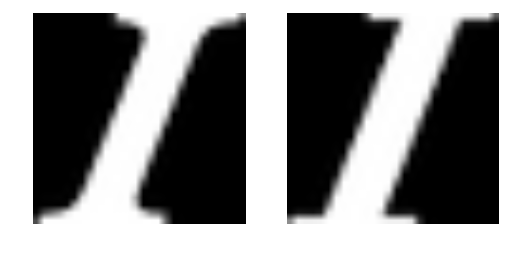

0.984871674329 364 491
8 8


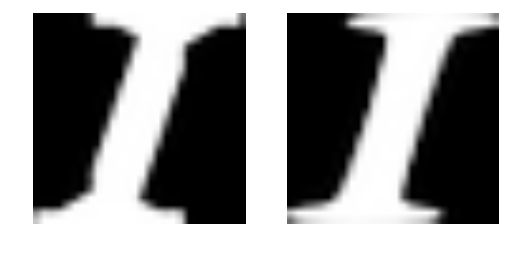

0.983722703531 372 975
5 5


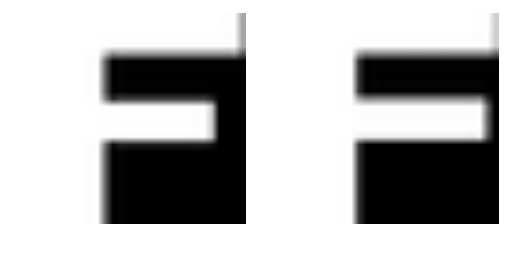

0.99606324872 383 809
8 8


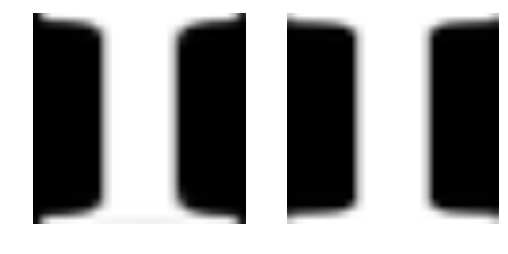

0.991279394366 383 900
8 8


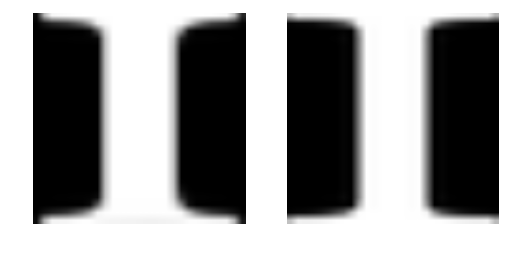

0.988330665976 383 976
8 8


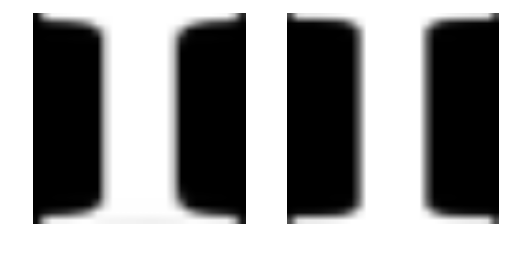

0.997748119291 393 407
8 8


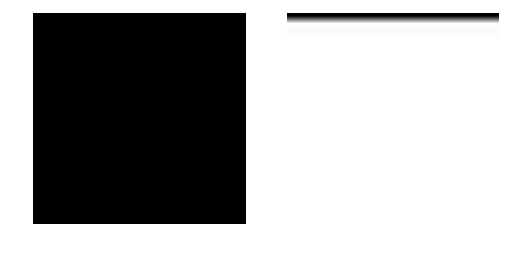

1.0 393 444
8 8


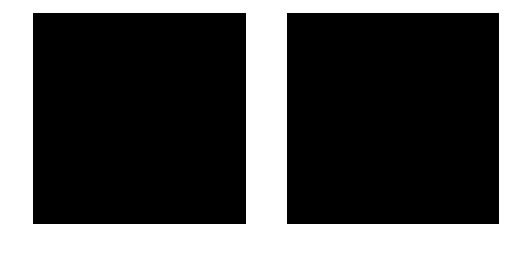

1.0 393 538
8 8


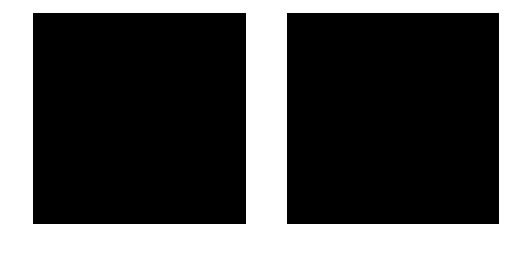

1.0 393 761
8 8


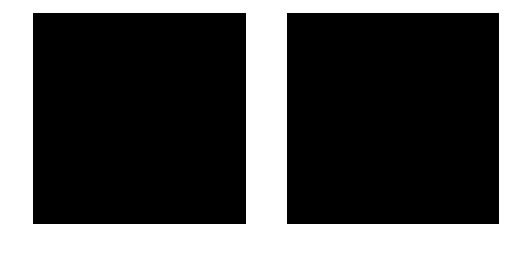

1.0 393 849
8 8


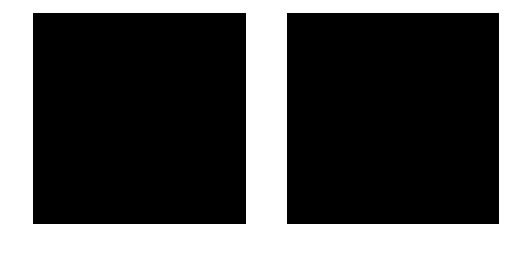

1.0 393 887
8 8


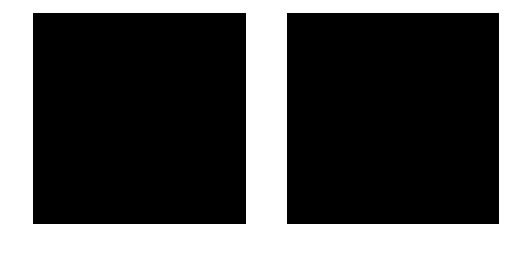

1.0 393 965
8 8


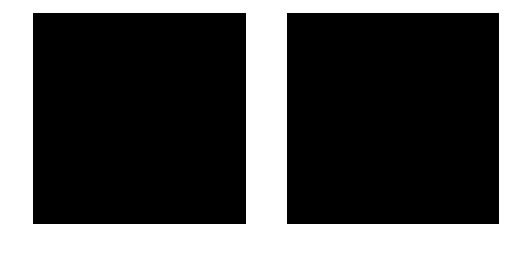

0.997748119291 407 444
8 8


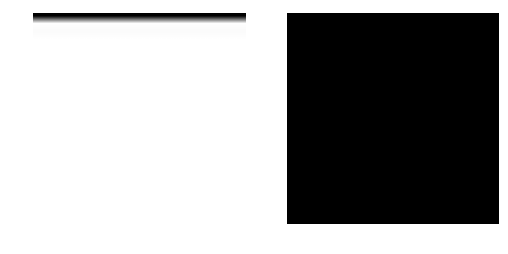

0.997748119291 407 538
8 8


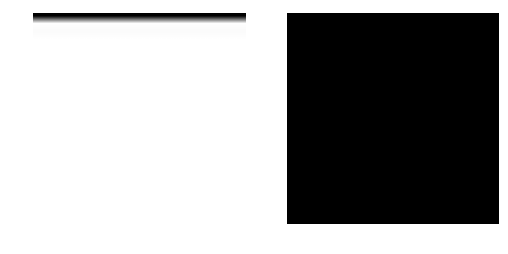

0.997748119291 407 761
8 8


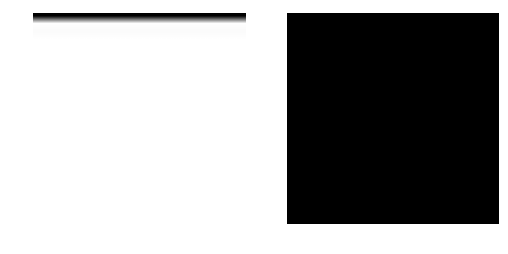

0.997748119291 407 849
8 8


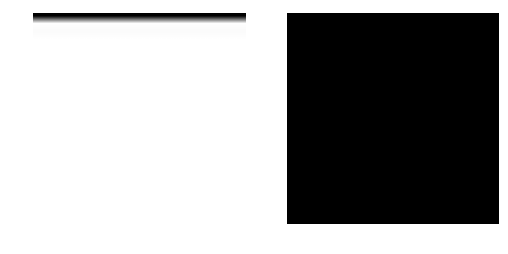

0.997748119291 407 887
8 8


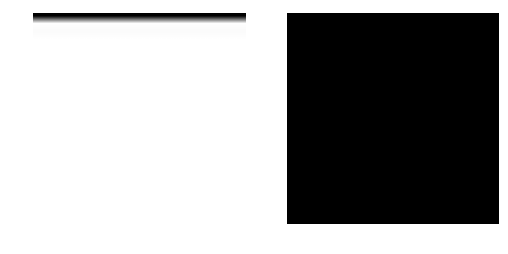

0.997748119291 407 965
8 8


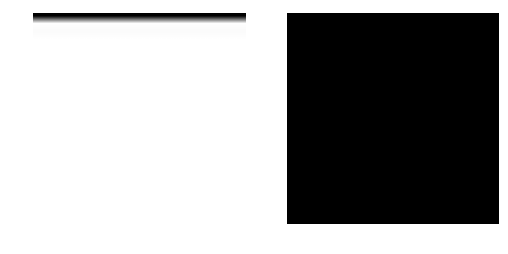

0.995258123148 409 564
5 2


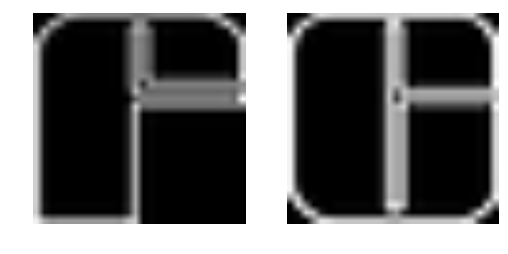

0.981876317412 421 751
8 8


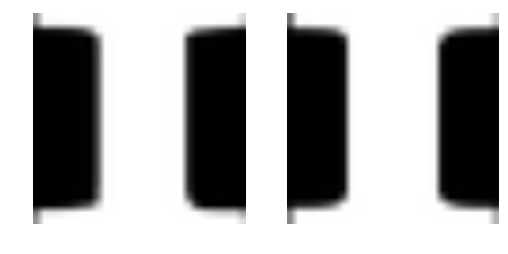

1.0 444 538
8 8


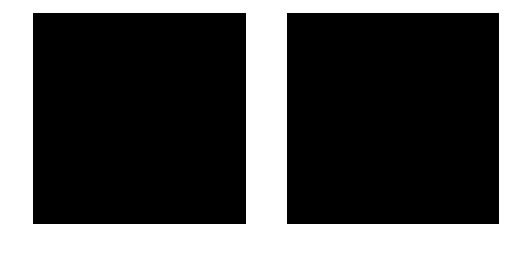

1.0 444 761
8 8


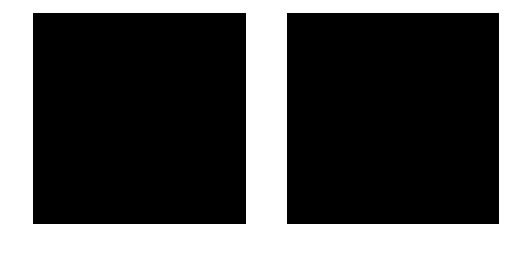

1.0 444 849
8 8


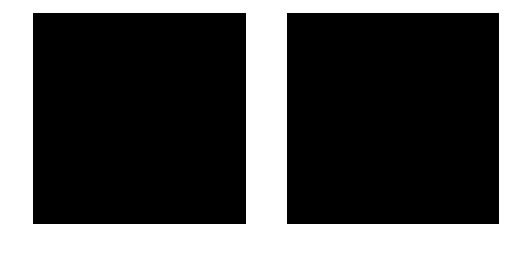

1.0 444 887
8 8


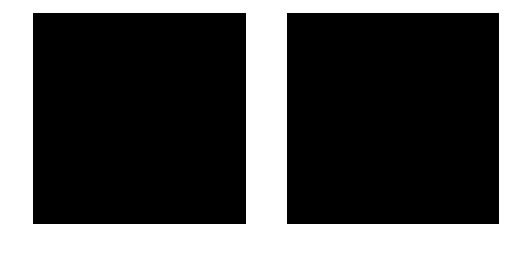

1.0 444 965
8 8


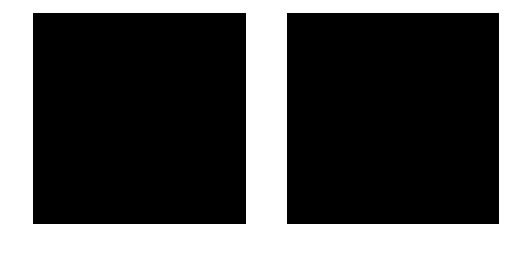

0.997369673569 448 963
6 6


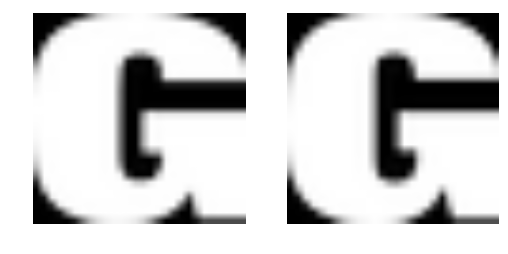

0.986345048063 480 629
7 7


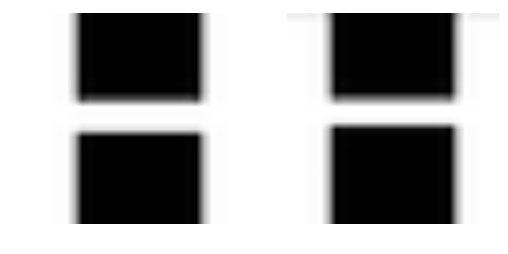

0.987321674824 480 789
7 7


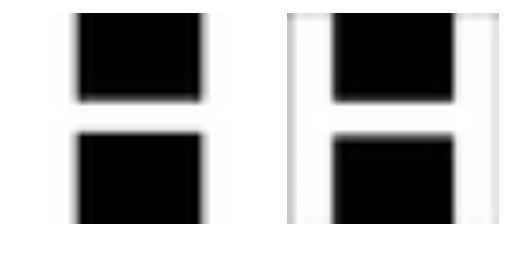

0.986776788719 487 634
9 9


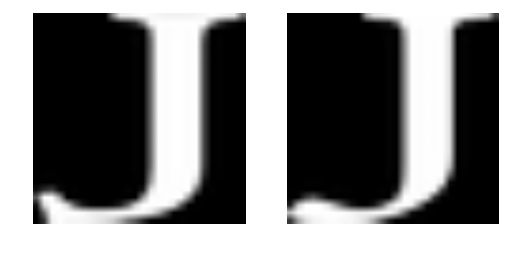

0.980535291135 510 846
2 2


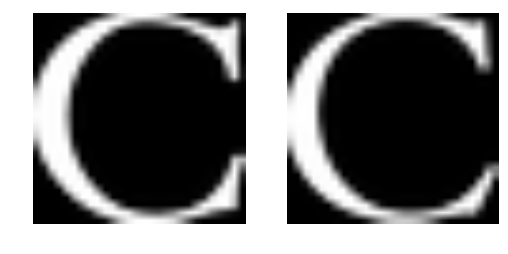

0.981889912859 536 876
3 3


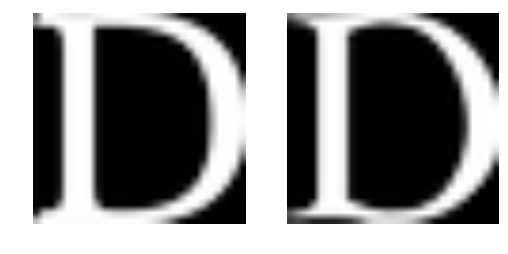

1.0 538 761
8 8


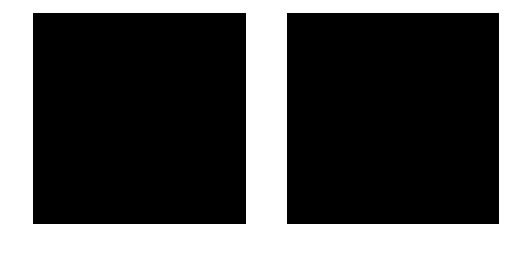

1.0 538 849
8 8


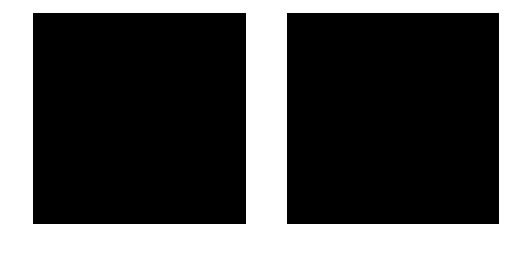

1.0 538 887
8 8


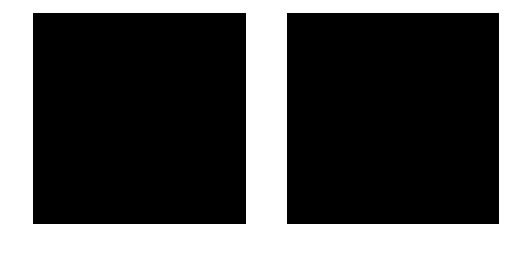

1.0 538 965
8 8


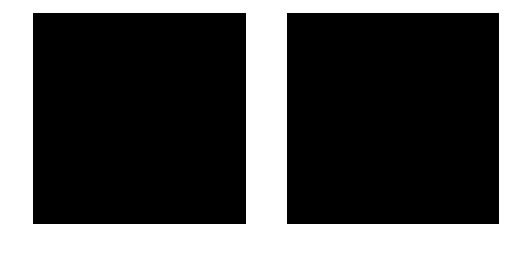

0.982450941578 542 824
7 7


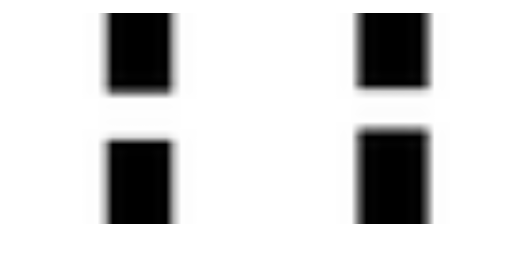

0.982566555962 544 609
2 2


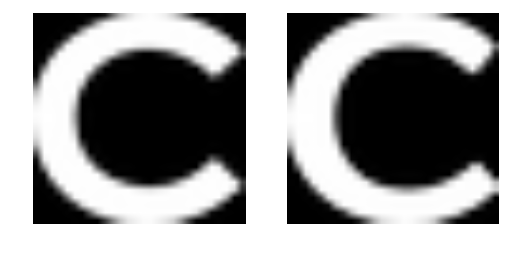

0.983852598816 546 780
8 8


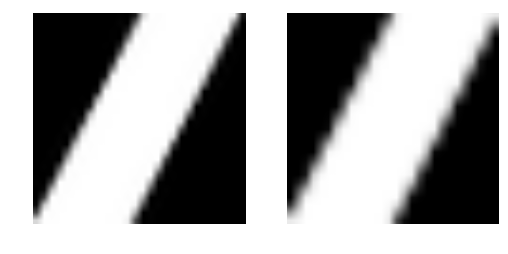

0.994597800076 546 895
8 8


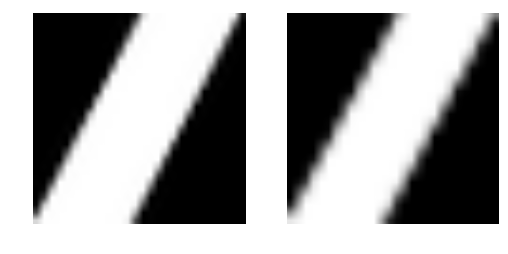

0.982052564621 577 777
8 8


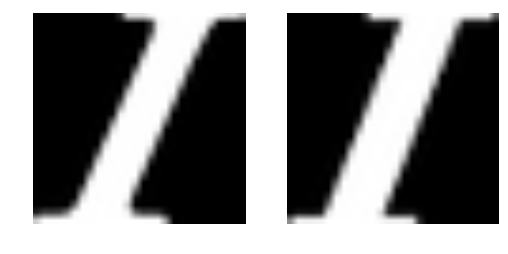

0.981859076768 578 904
3 3


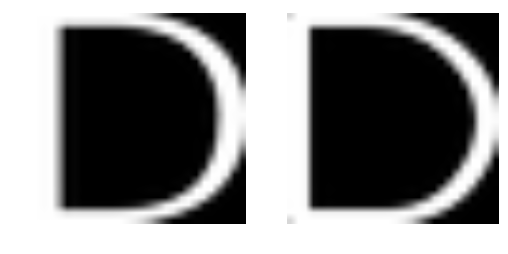

0.983034232631 610 841
2 2


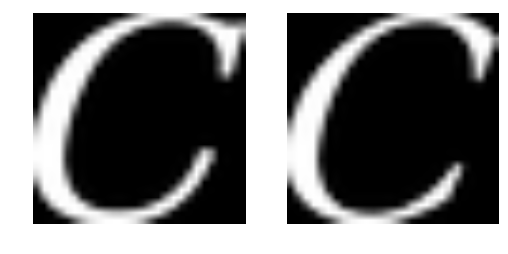

0.988003024831 628 816
5 5


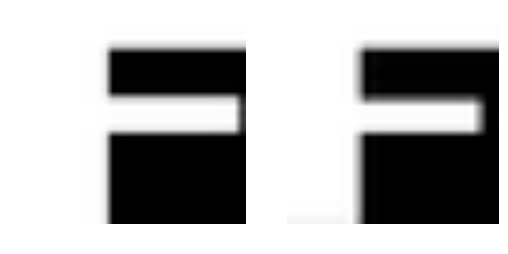

0.992811046075 671 747
7 7


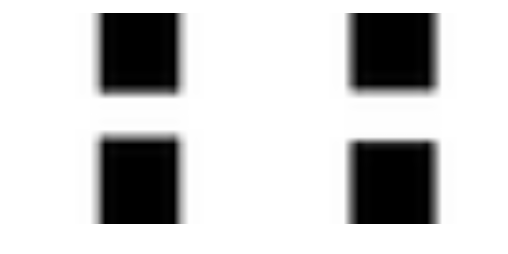

0.9829359781 693 882
0 0


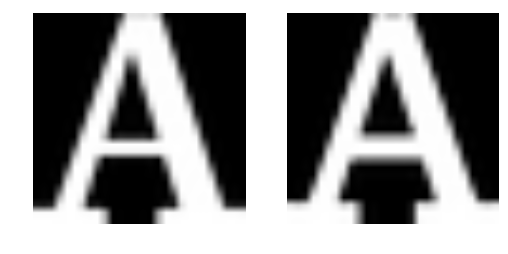

0.996432455257 695 871
9 9


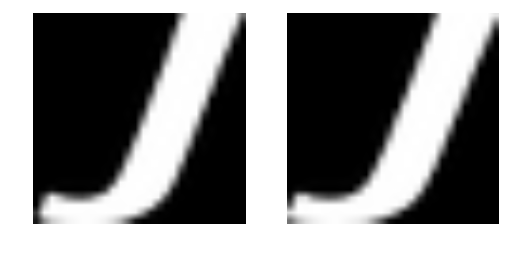

0.98715121299 695 994
9 9


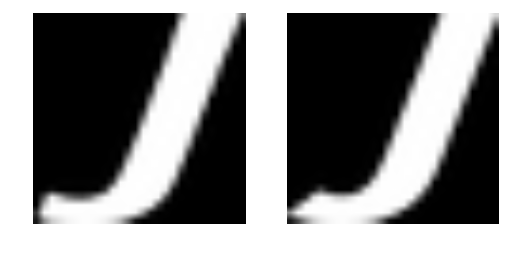

0.984946881421 731 767
3 3


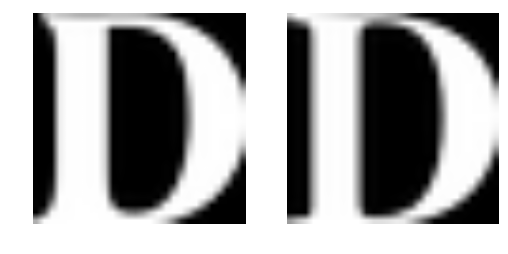

0.986732849851 737 826
7 7


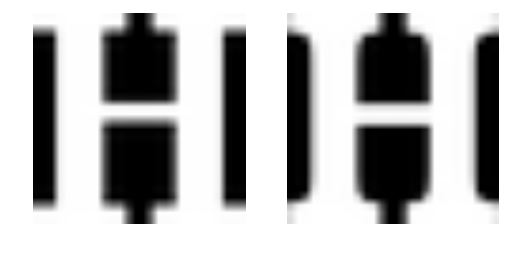

1.0 761 849
8 8


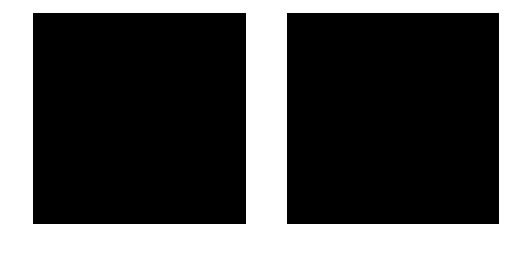

1.0 761 887
8 8


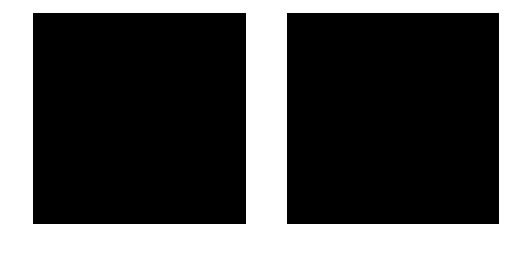

1.0 761 965
8 8


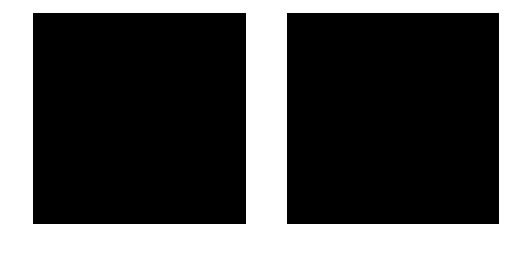

0.981347616762 779 833
5 5


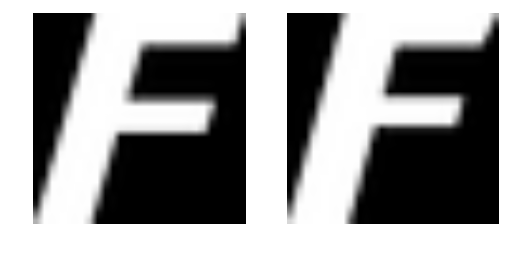

0.983229134232 780 895
8 8


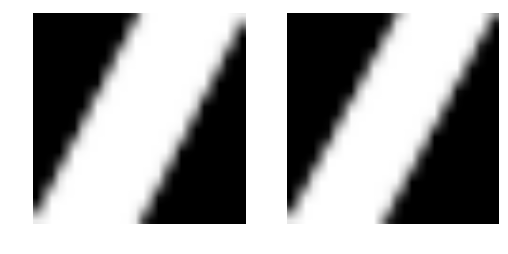

0.991845266894 809 900
8 8


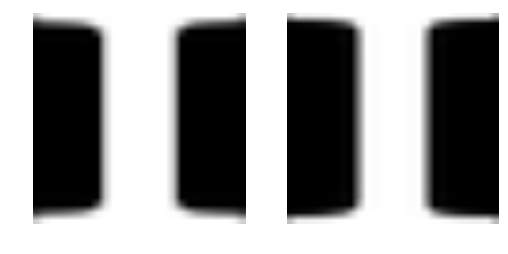

0.985603731126 809 976
8 8


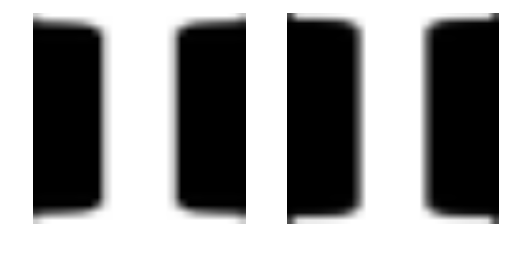

0.992658220232 835 924
6 1


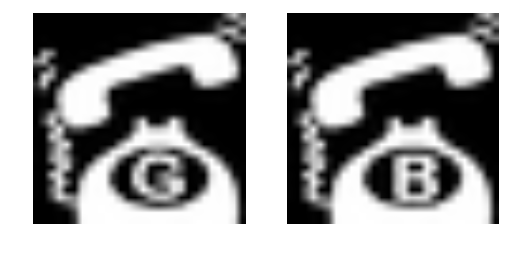

0.995574582834 848 997
6 6


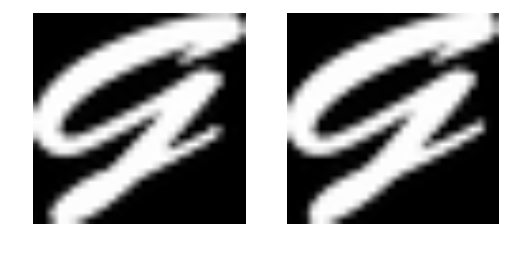

1.0 849 887
8 8


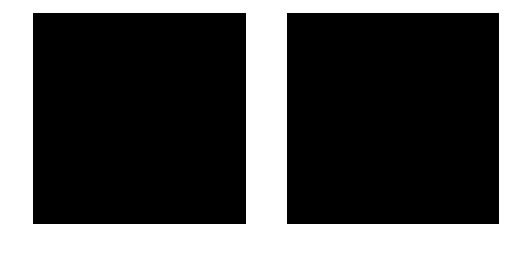

1.0 849 965
8 8


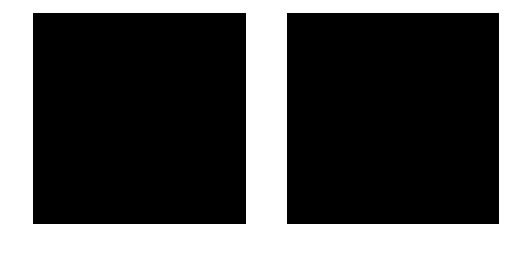

0.985456516966 852 949
9 9


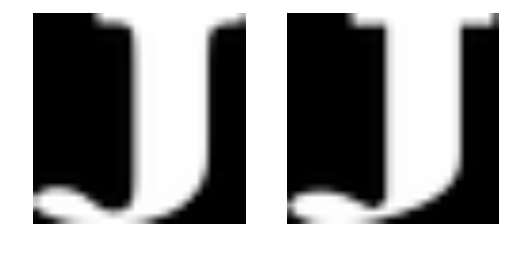

0.989116274752 871 994
9 9


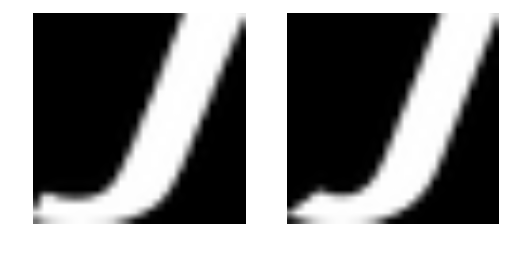

1.0 887 965
8 8


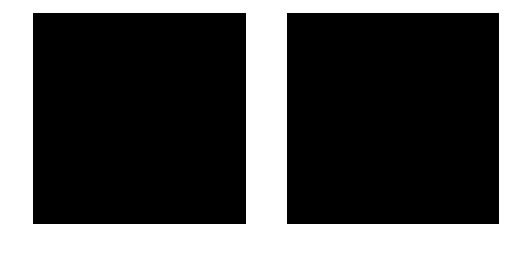

0.998174779583 900 976
8 8


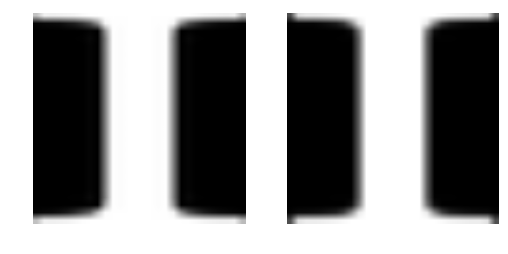

0.993876962457 917 937
6 6


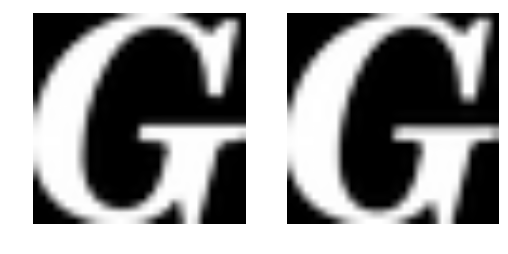

0.985133171082 950 983
9 9


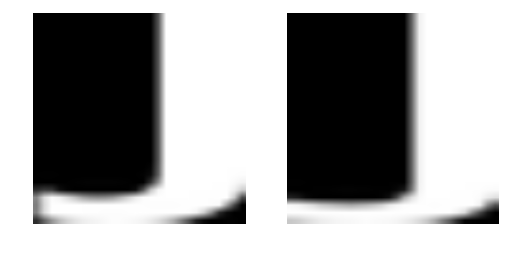

In [13]:
def similarity_of_lettes(a, b):
    return 1 - ((a - b) ** 2).mean()

n = 1000
for i in range(n):
    a = test_dataset[i]
    for j in range(i + 1, n):
        b = test_dataset[j]
        similarity = similarity_of_lettes(a, b)
        if(similarity > 0.98):
            print(similarity, i, j)
            print(test_labels[i], test_labels[j])
            show_letters((a, b))
            

---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [ ]:
N_samples = 1000
reshape_data_set     = train_dataset[0:N_samples].reshape(N_samples, 28*28)
reshape_test_dataset = test_dataset[0:1000].reshape(1000, 28*28)

lr = LogisticRegression()


from sklearn.grid_search import GridSearchCV

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              'penalty': ['l1', 'l2']} 
              

gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

gs = gs.fit(reshape_data_set, train_labels[0:N_samples])

print(gs.best_score_)
print(gs.best_params_)

In [66]:
N_samples = 5000

reshape_data_set     = train_dataset[0:N_samples].reshape(N_samples, 28*28)
reshape_test_dataset = test_dataset[0:1000].reshape(1000, 28*28)

lr = LogisticRegression(C=0.01, penalty = 'l2')
lr.fit(reshape_data_set, train_labels[0:N_samples])

accuracy = lr.score(reshape_test_dataset, test_labels[0:1000])
print(accuracy)

0.875


['D', 'G', 'F', 'H', 'H', 'H', 'H', 'B', 'F', 'J', 'G', 'A', 'J', 'A', 'A', 'C', 'C', 'I', 'C', 'I']


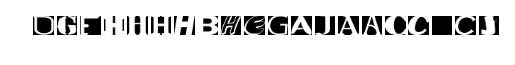

In [73]:
predict = lr.predict(reshape_test_dataset[0:20])
print([alphabetic_label(i) for i in predict])

show_letters(test_dataset[0:20])